# Cellular Operator App Sentiment Analysis

### Airlangga Parikesit Wibowo

## Description

The project aims to analyze user reviews of mobile applications used for cellular operators, such as MyTelkomsel, MyXL, and similar apps, by scraping data from the Google Play Store. The focus is on performing sentiment analysis using natural language processing (NLP) techniques to understand user satisfaction and identify common issues.

User reviews were scraped from the review of MyTelkomsel, MyXL, MyIM3, and MYSF app in Google Play Store using Python libraries google-play-scraper.

## Goals

1. __Sentiment Classification__: To classify reviews about each providers app into categories such as positive or negative, giving a clear picture of customer satisfaction.

2. __Identify Key Issues__: To identify common complaints, praises, or suggestions shared by customers, helping each operator understand the issues that need immediate attention or improvement.

3. __Competitor Comparison__: To compare sentiment scores between the four providers, allowing for a better understanding of public perception and brand image relative to each other.

## Benefits

1. __Enhanced Customer Experience__: The analysis can help each operator understand how customers perceive their services and what improvements they desire. This can lead to targeted service improvements and enhanced customer satisfaction.

2. __Brand Reputation Management__: Understanding public sentiment enables the operators to manage their brand reputation effectively. They can address negative sentiment quickly and reinforce positive feedback through targeted communication or marketing.
   
3. __Market Position Insight__: By comparing sentiment data across competitors, operators can identify strengths and weaknesses relative to their competitors. This can inform strategies for market positioning and help differentiate their offerings.
   
4. __Product & Service Optimization__: Identifying common complaints (e.g., network issues, data speed problems, confusing UI) can guide operators to prioritize fixes or new features. This can directly impact user retention and reduce churn.

# Import Libraries

In [41]:
!pip install --upgrade git+https://github.com/ariaghora/mpstemmer.git

  Cloning https://github.com/ariaghora/mpstemmer.git to /tmp/pip-req-build-bvyccrrm
  Running command git clone --filter=blob:none --quiet https://github.com/ariaghora/mpstemmer.git /tmp/pip-req-build-bvyccrrm
  Resolved https://github.com/ariaghora/mpstemmer.git to commit 25a5fd923af163a7eac3a5ec976984156ca8fa8b
  Preparing metadata (setup.py) ... done


In [42]:
!pip install python-levenshtein

In [43]:
import os
from tqdm import tqdm
import unicodedata
from pathlib import Path
from collections import Counter

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
import spacy
# # Load the spaCy English model
# nlp = spacy.load('id_core_web_sm')

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk import ngrams
from nltk.corpus import stopwords
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from mpstemmer import MPStemmer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load Data

In [44]:
ROOT = Path("/kaggle/input/provider-review")
telkom_app = pd.read_csv(os.path.join(ROOT, "MyTelkomsel-v2.csv"))
xl_app = pd.read_csv(os.path.join(ROOT, "MyXL-v2.csv"))
im3_app = pd.read_csv(os.path.join(ROOT, "MyIM3-v2.csv"))
smartfren_app = pd.read_csv(os.path.join(ROOT, "MySF-v2.csv"))

telkom_app["provider"] = "telkomsel"
xl_app["provider"] = "xl"
im3_app["provider"] = "indosat"
smartfren_app["provider"] = "smartfren"

In [45]:
# get each dataset information
for data in [telkom_app, xl_app, im3_app, smartfren_app]:
    print("#"*50)
    print(data["provider"].unique())
    print("#"*50)
    data.info()

##################################################
['telkomsel']
##################################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              800 non-null    object
 1   userName              800 non-null    object
 2   userImage             800 non-null    object
 3   content               800 non-null    object
 4   score                 800 non-null    int64 
 5   thumbsUpCount         800 non-null    int64 
 6   reviewCreatedVersion  654 non-null    object
 7   at                    800 non-null    object
 8   replyContent          716 non-null    object
 9   repliedAt             716 non-null    object
 10  appVersion            654 non-null    object
 11  sentiment             790 non-null    object
 12  provider              800 non-null    object
dtypes: int64(2), object(11)


In [46]:
# combine all data
all_df = pd.concat([telkom_app, xl_app, im3_app, smartfren_app], axis=0).reset_index(drop=True)
all_df.head()

reviewId                           userName  \
0  1528a551-7b22-4938-8c33-3361f3fa7e69                        Rizhal Zhal   
1  7457a35a-d5c5-4151-953d-eaabc457ff42                        Aby Bandung   
2  94b19387-7336-449d-9ae6-258868ef0606  Aldo lubuk hijau Aldo lubuk hijau   
3  34f5043c-bbdc-4b7f-8096-df145abf9599                     Rahmat Maulana   
4  417ed206-0dc4-4c4c-a54f-0420cde87021                   Latifa Assydiqia   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a/ACg8oc...   
1  https://play-lh.googleusercontent.com/a/ACg8oc...   
2  https://play-lh.googleusercontent.com/a/ACg8oc...   
3  https://play-lh.googleusercontent.com/a/ACg8oc...   
4  https://play-lh.googleusercontent.com/a/ACg8oc...   

                                             content  score  thumbsUpCount  \
0  telkomsel babi, jaringan sdh jdi lelet lalet l...    1.0            0.0   
1  tetap juara dan selalu menjadi produk telekomu...    5.0            0.0   
2                                             Mantap    5.0            0.0   
3  Rusak aplikasinya keluar sendiri mulu, login n...    3.0            0.0   
4                                               baik    5.0            0.0   

  reviewCreatedVersion               at  \
0                8.1.0  10/10/2024 9:08   
1                8.3.0  10/10/2024 9:08   
2                7.2.0  10/10/2024 9:06   
3                8.3.0  10/10/2024 9:05   
4                8.3.0  10/10/2024 9:00   

                                        replyContent         repliedAt  \
0  Hai Kak Rizhal. Mohon maaf untuk ketidaknyaman...   10/10/2024 9:31   
1  Hai Kak Aby, terima kasih tetap setia mengguna...  10/10/2024 13:55   
2  Hai Kak Aldo, terima kasih tetap setia menggun...  10/10/2024 13:56   
3  Hai Kak Rahmat. Mohon maaf untuk ketidaknyaman...  10/10/2024 13:16   
4  ai Kak Latifa, terima kasih tetap setia menggu...  10/10/2024 13:56   

  appVersion sentiment   provider  
0      8.1.0   negatif  telkomsel  
1      8.3.0   positif  telkomsel  
2      7.2.0   positif  telkomsel  
3      8.3.0   negatif  telkomsel  
4      8.3.0   positif  telkomsel

In [47]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewId              3198 non-null   object 
 1   userName              3198 non-null   object 
 2   userImage             3198 non-null   object 
 3   content               3198 non-null   object 
 4   score                 3198 non-null   float64
 5   thumbsUpCount         3198 non-null   float64
 6   reviewCreatedVersion  2705 non-null   object 
 7   at                    3198 non-null   object 
 8   replyContent          2589 non-null   object 
 9   repliedAt             2589 non-null   object 
 10  appVersion            2705 non-null   object 
 11  sentiment             3158 non-null   object 
 12  provider              3200 non-null   object 
dtypes: float64(2), object(11)
memory usage: 325.1+ KB


# EDA Part 1

## App Rating per Provider

Text(0.5, 1.0, 'Smartfren')

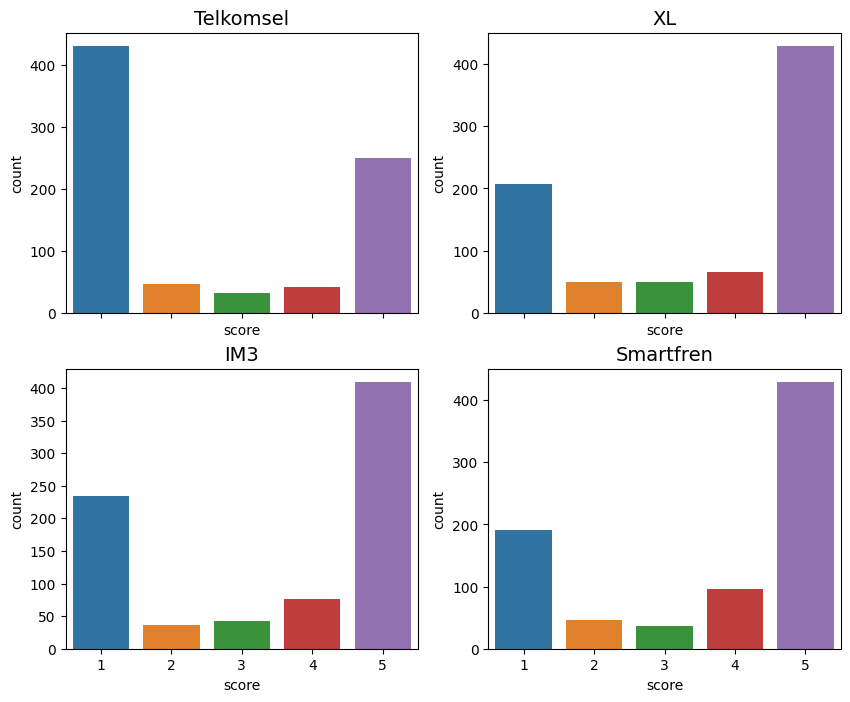

In [48]:
fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(10,8))

sns.countplot(telkom_app, x="score", ax=ax[0,0])
ax[0,0].set_title('Telkomsel', fontsize=14)

sns.countplot(xl_app, x="score", ax=ax[0,1])
ax[0,1].set_title('XL', fontsize=14)

sns.countplot(im3_app, x="score", ax=ax[1,0])
ax[1,0].set_title('IM3', fontsize=14)

sns.countplot(smartfren_app, x="score", ax=ax[1,1])
ax[1,1].set_title('Smartfren', fontsize=14)

## Most Liked Review

In [49]:
# get top 10 reviews of MyTelkomsel
def get_top_10_reviews(df):
    df_top_10_reviews = df[["content","score","thumbsUpCount"]]\
                            .sort_values(by="thumbsUpCount", ascending=False)\
                            .reset_index(drop=True)\
                            .head()

    for idx, row in df_top_10_reviews.iterrows():
        print(f"({idx}) Reviews:\n {row['content']}")
        print(f"Score: {row['score']}, Likes: {row['thumbsUpCount']}")
        print("")

In [50]:
get_top_10_reviews(telkom_app)

(0) Reviews:
 Telkomsel tu g bs buat nyimpen pulsa. Sedikit demi sedikit pulsa digerus hilang entah kemana. Padahal tdk ada penggunaan aplikasi sama sekali. Mengecewakan!!!
Score: 1, Likes: 181

(1) Reviews:
 HALLO apa ada cara untuk meningkatkan jaringan internet, selain di refresh? Kalo ada tolong beritahu. Jaringan dikamar saya parah sekali mulai dari tahun ini. Kesabaran itu ada batas nya. Saya perbarui, no respon dan tetep jaringan nya puarah
Score: 1, Likes: 20

(2) Reviews:
 Jangan terlalu buat tampilan yg berlebihanlah. Fungsi apk kalian cuma buat beli paket sma cek paket doang. Jadi jangan banyak gaya untuk bikin tampilan yg sok keren. Makin sering updat bukannya apk makin enteng, malah makin lelet kayak siput. Data update bukannya kecil. Malah berpuluh² MB mulu. Tp apk kagak makin bagus.
Score: 1, Likes: 7

(3) Reviews:
 Telkomsel tolong saya setiap menggunakan data selaluu aja ngelag ga jelas kirim foto aja video ga bisa bisa dulu kenceng sekarang lambat banget di HP temen s

In [51]:
get_top_10_reviews(xl_app)

(0) Reviews:
 Aplikasinya bagus & mudah untuk digunakan, promonya juga banyak, harga kuota & produk lainnya cukup murah, proses transaksinya cepat, sinyalnya selalu 4G, kualitas jaringannya bagus & lancar buat buka Apk, main game, dll.. Saya terbantu oleh myXL untuk aktivitas sehari-hari. Good luck myXL..
Score: 5, Likes: 71

(1) Reviews:
 Untuk kendala xl ..sekarang masih tetep di sinyall jaringan...saya beli paket dari aplikasi xl malah parah dikit dikit loding..jalan lagi sebentar..loding lagi ampe lama..update,bonus itu ini mau buka aplikasi nya aja..ga bisa..malah ada gambar orang lagi ngeluh..terus aja gitu..jadi males kalo jaringannya seperti ini terus .belum ada prubahan yang signifikan...yang bener bisa bikin puas pengguna XL..kenapa untuk daerah sukoanyar wajak sinyal xl ko susah banget..PRIORITAS & HOME di mana..
Score: 2, Likes: 36

(2) Reviews:
 Dari segi harga paketan XL memang paling affordable dibanding operator lain, namun sayang sekali untuk SINYAL SERING HILANG! Kece

In [52]:
get_top_10_reviews(im3_app)

(0) Reviews:
 iklan maksa dan ganggu banget, selalu muncul di layar hp udah klik tolak tetep aja kebuka dibawa ke browser
Score: 1.0, Likes: 101.0

(1) Reviews:
 Untuk fitur lock Pulsa di adain kembali karna sering kali nyedot tidak jelas berkurang padahal data di matikan dan performa apk agar di buat ringan karna loadingnya terlalu lama kadang mungkin itu masukan saya 🙏di tunggu update nya terima kasih
Score: 4.0, Likes: 50.0

(2) Reviews:
 saya ingin melaporkan keluhan atas jaringan IM3 ,yang sangat leg banget jaringan nya mohon di perbaiki lagi
Score: 1.0, Likes: 2.0

(3) Reviews:
 kartu tukang maling pulsa,,setiap ada pulsa sisa entah berapa pun ga bakal hilang anehnya hilang gatau Kemana tiba² SMS berlangganan kan gajelas,,,bisa ga 1 hari aja pulsa awet ga di maling??
Score: 1.0, Likes: 1.0

(4) Reviews:
 Lag banget tolong diperbaiki lagi sinyal nya ga ada banget daerah saya biasanya banyak makin kesini ngelag bangettt😡😡😡😡😡
Score: 1.0, Likes: 1.0



In [53]:
get_top_10_reviews(smartfren_app)

(0) Reviews:
 Jangan pake Smartfren di luar kota besar...bikin kesal...tiap akhir pekan sinyal melemah atau bahkan hilang...... Udah restart puluhan kali ampe rusak tombol powernya sinyal tetep aja hilang.....sekarang dinaikan tarifnya...keren.... jangkauan sinyal sangat terbatas
Score: 1, Likes: 140

(1) Reviews:
 ga puas pake smartfren. lemot banget padahal sinyal banyak, terus entah kenapa kok boros ya... ga mungkin jejak pemakaian data di hp aku yang salah, biasanya pake yang lain 10gb itu cukup sampe 2 minggu padahal dipake streaming, musikan, sosmed, tiktok, browsing.. tapi ini 10gb cuma dua hari doang udah kesedot 6gb, padahal cuma kupake wasap aja, scroll tiktok cuma berapa menit itu pun riset pelajaran. sisanya aplikasi offline... sumpah ga memuaskan, ga lagi-lagi, mending pake yang lain.
Score: 1, Likes: 53

(2) Reviews:
 Provider sialan yang pernah ada, kecepatan jaringan busuk sialannn!!! Udah gitu kecepatan download 1 Mbps pun ga konsisten selalu dibawah itu, sya tinggal d

# Data Preprocessing

## Missing Value

In [54]:
# check missing value
all_df.isnull().sum()

reviewId                  2
userName                  2
userImage                 2
content                   2
score                     2
thumbsUpCount             2
reviewCreatedVersion    495
at                        2
replyContent            611
repliedAt               611
appVersion              495
sentiment                42
provider                  0
dtype: int64

When working on data labelling, I leave the sentiment empty for review that only contain emoji.

In [55]:
nan_idx = all_df[(all_df['sentiment'].isnull()) & (all_df['content'].isnull())].index
# drop the index
all_df = all_df.drop(nan_idx, axis=0).reset_index(drop=True)
# nan_idx

## Data Type Correction

In [56]:
all_df["at"] = pd.to_datetime(all_df['at'], format='%m/%d/%Y %H:%M')
telkom_app["at"] = pd.to_datetime(telkom_app['at'], format='%m/%d/%Y %H:%M')
xl_app["at"] = pd.to_datetime(xl_app['at'], format='%m/%d/%Y %H:%M')
im3_app["at"] = pd.to_datetime(im3_app['at'], format='%m/%d/%Y %H:%M')
smartfren_app["at"] = pd.to_datetime(smartfren_app['at'], format='%m/%d/%Y %H:%M')

all_df["at"]

0      2024-10-10 09:08:00
1      2024-10-10 09:08:00
2      2024-10-10 09:06:00
3      2024-10-10 09:05:00
4      2024-10-10 09:00:00
               ...        
3193   2024-09-25 09:35:00
3194   2024-09-25 09:27:00
3195   2024-09-25 09:12:00
3196   2024-09-25 08:46:00
3197   2024-09-25 08:44:00
Name: at, Length: 3198, dtype: datetime64[ns]

## Emoji Handling

In [57]:
# https://en.wikipedia.org/wiki/List_of_emoticons
emoji_pattern = re.compile(
    r'^[\U0001F600-\U0001F64F'  # emoticons
    r'\U0001F300-\U0001F5FF'  # misc Symbols and Pictographs
    r'\U0001F680-\U0001F6FF'  # transport and Map Symbols
    r'\U0001F700-\U0001F77F'  # alchemical Symbols
    r'\U0001F780-\U0001F7FF'  # geometric Shapes Extended
    r'\U0001F800-\U0001F8FF'  # supplemental Arrows-C
    r'\U0001F900-\U0001F9FF'  # supplemental Symbols and Pictographs
    r'\U0001FA00-\U0001FA6F'  # chess Symbols
    r'\U0001FA70-\U0001FAFF'  # symbols and Pictographs Extended-A
    r'\U00002700-\U000027BF'  # dingbats
    r'\U000024C2-\U0001F251'  # enclosed characters
    r']+$'
)

# filter the DataFrame to only show rows where 'text' contains only emojis
all_df[all_df['content'].apply(lambda x: bool(emoji_pattern.match(x)))]

reviewId                   userName  \
103   ead58072-0bcb-4b78-87a9-b58eeea9b4dd                 Rizky Opal   
110   24cb0a82-7da9-4274-adbd-af5a5fd39ca0                 indra jaya   
242   3a90cdb7-cc2d-42a4-bc23-a7fa38accb5e            Tony Hermansyah   
475   2c95f56c-e790-4007-b0a6-7aa8709ae76a                BMB BERJAYA   
611   84189783-6a57-4e74-aa9c-e9b3028f630a                Erni Erni23   
682   229cc98a-da4a-4ca6-8209-bb2702eb647d     Syaiful Makalalag Ipul   
735   aa440ea4-335a-45ed-b022-68b630de6181                        Adi   
750   ef2fa9be-f763-42a8-921a-9ac6591c73c1                 Evi Wilsen   
785   21f40c43-fbca-4209-92a2-e034211f725d                   Vivo Y03   
809   a09e74a9-61be-4968-b6a1-61d9d44d91f3               Ferdi Juntak   
979   36ef6285-15f0-4385-abfe-a6a9f0c081e5              Titin Hartini   
1013  2a6ec661-f0f7-43ef-8f0f-4fdf0d156b39      Dewa Tansah Sumringah   
1205  13748cd3-7d1a-455f-ab87-239f8e31ad79                 Khoy Riyah   
1251  34256172-d615-493f-ac39-586ac3232bd2          Putri Segan indah   
1344  032658a4-e668-45a6-b0c6-fe1e94dca614             Nadira Thafana   
1409  1dceaa16-c3b1-499d-a14c-a71c83298392        Wildan a Apriansyah   
1414  f9516f03-40fc-4107-9fbc-ff76f06a7eb5           Wasilah Syarifah   
1465  1ebe4306-50c1-4785-8408-78def2d16b0a                 Dwi Naufal   
1489  a33dec69-5301-4ae3-90c9-e4c7c7b8766f               Rika Nuryati   
1611  a109cfaa-75f6-4e9c-a6e2-07d560dda778                 Arpin Saka   
1692  9a0e759d-80eb-4b03-874d-b4b95df5980a             Indri Indriani   
1696  df4652d9-a9ec-4251-abbc-222c8da843f7              istrina nalle   
1781  42ab7c56-6164-4516-ae9d-9de4b6a35c70                Dimas Lidia   
1925  eaa33bd0-7eaa-41de-aa5f-d31c476bb861                   Adul Bpx   
1946  fc4cc641-b83c-4ccf-9f5d-6c5365825ac8                Yadi Bejing   
2106  7cddb892-6e57-4169-bbd0-6b5d53a14d89                 siti afifa   
2213  350b764a-ad5e-49e5-8258-d572bf495b78            Faiz Abdul aziz   
2291  5bbf6fa7-8ea1-4143-8801-fc71221c3c26               Zhang Yaqian   
2353  21cf9ecc-581c-490d-93d6-92ebadbcc210                 Ubai Dilla   
2394  9d8592cf-2b08-488e-9d5e-1e24806381ea               dedi pratama   
2440  9bc563f0-5997-4c98-a9c3-5041651f2876       D.Donald Pandianngan   
2459  c2f307ce-d4c8-4104-b553-e66ea256c7f7                 Mbali Bong   
2492  e556d166-1e31-409f-8770-ecac70d6aab1                 Adin Stile   
2567  9f677c8c-6837-4ad9-b78b-135e9bc00372                    luk man   
2677  444b5c42-7f76-4f90-9053-969924751bf6                 Paul Fauza   
2680  ff60e6b3-6125-408e-921b-d854f59ce388             Resal Heryawan   
2718  736f455e-958f-418b-8cd4-a4263f55342b                 Ibnu Pasha   
2748  e004381b-e43c-45c4-9302-94c8a56796c9         one piece samAnime   
2825  b7855d42-d703-4bdf-bded-7d7f2dd6b4de                Eni Suryani   
2861  28619cfd-0711-46d9-833f-61554a92d8dc               Wildah Indah   
2904  4b2ba79b-6ccd-4875-a895-2ede76c8e705              Purwodadi New   
2965  830997fc-6c1f-4954-b7c1-9e3ab834911e                    M Arsha   
3012  30e42156-f01b-4bb3-a4fa-8e9a0e0ade44  Naff 4 You (Yakin Deck ?)   
3080  c933b7e6-2e4d-430e-964a-02e5bb8616c7                 Feri Yanto   
3121  22a2cd7b-31da-4967-b7e6-71eb10cbbff3             Arif Saskara12   

                                              userImage               content  \
103   https://play-lh.googleusercontent.com/a-/ALV-U...                   👍👍👍   
110   https://play-lh.googleusercontent.com/a/ACg8oc...                 👍👍👍👍👍   
242   https://play-lh.googleusercontent.com/a-/ALV-U...                👍👍👍👍👍👍   
475   https://play-lh.googleusercontent.com/a-/ALV-U...                    👍🏻   
611   https://play-lh.googleusercontent.com/a/ACg8oc...                     👍   
682   https://play-lh.googleusercontent.com/a/ACg8oc...                     👍   
735   https://play-lh.googleusercontent.com/a/ACg8oc...                     👍   
750   https://play-lh.googl

Because reviews that contain only emoji lack context needed for analysis, we will remove these rows.

In [58]:
# get index containing emoji-only reviews
emoji_idx = all_df[all_df['content'].apply(lambda x: bool(emoji_pattern.match(x)))].index

# drop the index
all_df = all_df.drop(emoji_idx, axis=0).reset_index(drop=True)

In [59]:
# get all reviews containing emoji
all_df[all_df['content'].str.contains(r'[\u263a-\U0001f645]')].head()

reviewId             userName  \
7   d9315796-67fa-40c3-baa7-ff2ffa545739            ALBARI 24   
9   f2064746-d278-46d1-a279-79751d4f0741  M Denny Eka Saputra   
25  ad5be195-06a3-4528-9d81-8ce50f9e5c7c         Alif Stevano   
40  5f986931-6f01-4e1a-ab22-180d29fd8a03    Salahuddin Ismail   
55  80428524-b647-4f34-b16a-ca5d7be117ef        Liya Aprianti   

                                            userImage  \
7   https://play-lh.googleusercontent.com/a-/ALV-U...   
9   https://play-lh.googleusercontent.com/a-/ALV-U...   
25  https://play-lh.googleusercontent.com/a-/ALV-U...   
40  https://play-lh.googleusercontent.com/a-/ALV-U...   
55  https://play-lh.googleusercontent.com/a-/ALV-U...   

                                              content  score  thumbsUpCount  \
7   Mantap..., banyak bonusnya dan diskon khusus P...    5.0            0.0   
9                                              Good 💯    5.0            0.0   
25  Gua padahal pake wifi tapi paket nya kesedot j...    2.0            0.0   
40                                               👌oke    5.0            0.0   
55                                       sangat baik👍    5.0            0.0   

   reviewCreatedVersion                  at  \
7                   NaN 2024-10-10 08:40:00   
9                 8.3.0 2024-10-10 08:39:00   
25                8.3.0 2024-10-10 07:36:00   
40                8.3.0 2024-10-10 06:32:00   
55                8.3.0 2024-10-10 05:37:00   

                                         replyContent         repliedAt  \
7   Hai Kak Albari, terima kasih tetap setia mengg...  10/10/2024 15:59   
9   Hai Kak Denny, terima kasih tetap setia menggu...  10/10/2024 16:00   
25  Hai Kak Alif. Mohon maaf untuk ketidaknyamanan...  10/10/2024 13:00   
40  Hai Kak Salahuddin, terima kasih tetap setia m...   10/10/2024 7:27   
55  Hai Kak Liya, terima kasih tetap setia menggun...   10/10/2024 7:28   

   appVersion sentiment   provider  
7         NaN   positif  telkomsel  
9       8.3.0   positif  telkomsel  
25      8.3.0   negatif  telkomsel  
40      8.3.0   positif  telkomsel  
55      8.3.0   positif  telkomsel

## Text Cleaning

In [60]:
def lowercase(texts):
    """ Converts all characters in the input text to lowercase.
    
    Args:
        texts (str): A string of text to be converted to lowercase.
    Returns:
        str: The input text with all characters converted to lowercase.
    Example:
        >>> lowercase("Ini Adalah Teks")
        'ini adalah teks'
    """
    words = texts.split()
    words = [word.lower() for word in words]
    return " ".join(words)

def remove_stopwords(texts):
    """ Removes stopwords from the input text based on a predefined list of stopwords in Indonesian.
    
    Args:
        texts (str): A string of text from which stopwords will be removed.
    Returns:
        str: The text with stopwords removed.
    Example:
        >>> remove_stopwords("ini adalah sebuah contoh teks")
        'contoh teks'
    """
    words = texts.split()
    words = [word for word in words if word not in stopwords.words("indonesian")]
    return " ".join(words)

def add_space_after_punctuation(text):
    """ Add space after punctuations so it can be removed using remove_punctuation.
    preventing word to combine after punctuation removal
    
    Args:
        texts (str): A string of text from which stopwords will be removed.
    Returns:
        str: The text with added space after punctuation.
    Example:
        >>> add_space_after_punctuation("Aplikasi yang sangat buruk,jelek,pembohong")
        'Aplikasi yang sangat buruk, jelek, pembohong'
    """
    text = re.sub(r'([.,!?;:])([^\s])', r'\1 \2', text)
    return text

def remove_punctuation(texts):
    """ Removes punctuation characters from the input text.
    
    Args:
        texts (str): A string of text from which punctuation will be removed.
    Returns:
        str: The text without any punctuation.
    Example:
        >>> remove_punctuation("Halo! Ini, adalah: contoh.")
        'Halo Ini adalah contoh'
    """
    texts = re.sub(r"[^\w\s]", " ", texts)
    return texts

def remove_non_ascii(texts):
    """ Removes non-ASCII characters from the input text.
    
    Args:
        texts (str): A string of text from which non-ASCII characters will be removed.
    Returns:
        str: The text with non-ASCII characters removed.
    Example:
        >>> remove_non_ascii("café naïve résumé")
        'cafe naive resume'
    """
    words = texts.split()
    words = [unicodedata.normalize("NFKD", word)\
             .encode("ascii", "ignore")\
             .decode("utf-8", "ignore") for word in words]
    return " ".join(words)

def remove_urls(texts):
    """ Removes URLs from the input texts.
    
    Args:
        texts (str): A string of texts from which URLs will be removed.
    Returns:
        str: The texts without any URLs.
    Example:
        >>> remove_urls("Check this out: https://example.com")
        'Check this out:'
    """
    url_pattern = re.compile(r"https?://\S+|www\.\S+")
    return url_pattern.sub(r"", texts)

def stemmer(texts):
    """ Reduces words to their root form using a stemming algorithm for Indonesian.
    
    Args:
        texts (str): A string of text to be stemmed.
    Returns:
        str: The text with words reduced to their root forms.
    Example:
        >>> stemmer("makanan minuman berjalan")
        'makan minum jalan'
    """
#     stem = StemmerFactory()
    stemmer = MPStemmer()
    words = texts.split()
    texts = [stemmer.stem_kalimat(word) for word in words]
    return " ".join(words)

def load_kamus_alay():
    slang_df = pd.read_csv("/kaggle/input/kamus-alay/colloquial-indonesian-lexicon-v3.csv")
    return slang_df[["slang", "formal"]].drop_duplicates() 

def replace_slang(texts):
    """ Replaces slang words in the input texts with their formal equivalents using 
    a slang dictionary.
    
    Args:
        texts (str): A string of texts containing slang words.
    Returns:
        str: The texts with slang words replaced by their formal equivalents.
    Example:
        >>> replace_slang("gw mau makan")
        'saya mau makan'
    """
    slang_df = load_kamus_alay()
    slang_dict = dict(zip(slang_df['slang'], slang_df['formal']))
    words = texts.split()
    normalized_words = [slang_dict.get(word.lower(), word) for word in words]
    return " ".join(normalized_words)

def remove_irrelevant_words(text):
    """ Removes specific irrelevant words (etc. brand name) from the input text if they stand alone.
    (for some reason, "nya" are one of most used word after preprocessing, so
    remove that word)
    Args:
        text (str): A string of text from which irrelevant words will be removed.
    Returns:
        str: The text with irrelevant standalone words removed.
    Example:
        >>> remove_irrelevant_words("Aplikasi ini lebih bagus dari Telkomsel myTelkomsel")
        'Aplikasi ini lebih bagus dari myTelkomsel'
    """
    irrelevant_words = ["my","telkomsel","indihome","telkom", "mytelkomsel","mytelkom",
                        "xl", "x1", "axis","myxl", "indosat","im3","myim3","smartfren","sf",
                        "mysf","smarfren","nya","myindihome"]
    # Compile a regex pattern to match whole words
    pattern = r'\b(?:' + '|'.join(re.escape(word) for word in irrelevant_words) + r')\b'
    # Replace matched standalone words with an empty string
    cleaned_text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    # Remove extra spaces
    cleaned_text = ' '.join(cleaned_text.split())
    return cleaned_text

def normalize_repeated_characters(text):
    """ fix letter repetition
    Args:
        text (str): A string of text from which repeated letter in word will be removed.
    Returns:
        str: The text with repeated letter removed.
    Example: 
        "mmantap" -> "mantap", 
        "mannntap" -> "mantap", 
        "mantapp" -> "mantap" 
    """
    text = re.sub(r'(.)\1+', r'\1', text)
    return text

def remove_review_less_than_n_words(texts, n=2):
    words = texts.split()
    words = [word for word in words if len(words) > n]
    return " ".join(words) 
    
# Preprocessing function
def preprocessing_texts(df):
    """ Applies a preprocessing text pipeline to clean the texts in a DataFrame.
    
    Args:
        df (pd.DataFrame): The original DataFrame containing a 'content' column with 
        the text data.
    Returns:
        pd.DataFrame: The DataFrame with an additional 'clean_text' column containing 
        the cleaned texts.
    """
    tqdm.pandas(desc="remove_urls")
    df["clean_text"] = df["content"].progress_apply(lambda x: remove_urls(x)) 
    tqdm.pandas(desc="lowercase")
    df["clean_text"] = df["clean_text"].progress_apply(lambda x: lowercase(x)) 
    tqdm.pandas(desc="remove_non_ascii")
    df["clean_text"] = df["clean_text"].progress_apply(lambda x: remove_non_ascii(x)) 
    tqdm.pandas(desc="add_space_after_punctuation")
    df["clean_text"] = df["clean_text"].progress_apply(lambda x: add_space_after_punctuation(x)) 
    tqdm.pandas(desc="remove_punctuation")
    df["clean_text"] = df["clean_text"].progress_apply(lambda x: remove_punctuation(x))
    tqdm.pandas(desc="replace_slang")
    df["clean_text"] = df["clean_text"].progress_apply(lambda x: replace_slang(x)) 
    tqdm.pandas(desc="stemmer")
    df["clean_text"] = df["clean_text"].progress_apply(lambda x: stemmer(x))
#     tqdm.pandas(desc="remove_stopwords")
#     df["clean_text"] = df["clean_text"].progress_apply(lambda x: remove_stopwords(x)) 
    tqdm.pandas(desc="remove_brand_name")
    df["clean_text"] = df["clean_text"].progress_apply(lambda x: remove_irrelevant_words(x)) 
    tqdm.pandas(desc="normalize_repeated_characters")
    df["clean_text"] = df["clean_text"].progress_apply(lambda x: normalize_repeated_characters(x)) 
    tqdm.pandas(desc="remove_review_less_than_n_words")
    df["clean_text"] = df["clean_text"].progress_apply(lambda x: remove_review_less_than_n_words(x, 2))
    return df

In [61]:
# apply preprocessing 
all_df = preprocessing_texts(all_df)

remove_review_less_than_n_words: 100%|██████████| 3153/3153 [00:00<00:00, 182590.17it/s]


## Empty String/Missing value

In [62]:
all_df.isnull().sum()

reviewId                  0
userName                  0
userImage                 0
content                   0
score                     0
thumbsUpCount             0
reviewCreatedVersion    492
at                        0
replyContent            599
repliedAt               599
appVersion              492
sentiment                 9
provider                  0
clean_text                0
dtype: int64

In [63]:
# because review less than 2 words were replaced by empty string
# get the index of empty review
empty_str_idx = all_df.query("clean_text==''").index
print(f"Count of empty str after cleaning: {len(empty_str_idx)}")

# drop the index
all_df = all_df.drop(empty_str_idx, axis=0).reset_index(drop=True)

Count of empty str after cleaning: 1237


In [64]:
all_df.to_csv("/kaggle/working/preprocessed_df_ft.csv", index=False)

# EDA Part 2 (Post-processing)

## Class Proportion

In [65]:
def class_prop(df):
    class_total = df['sentiment'].value_counts()
    class_total_pct = df['sentiment'].value_counts(normalize=True) * 100
    class_table = pd.concat([class_total, class_total_pct], axis=1)
    return class_table

print(class_prop(all_df))

           count  proportion
sentiment                   
negatif     1376   72.041885
positif      534   27.958115


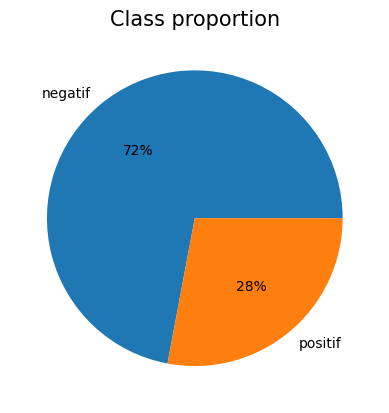

In [66]:
train_class_prop = class_prop(all_df)

plt.pie(train_class_prop['proportion'], labels=train_class_prop.index, autopct='%.0f%%')
plt.title('Class proportion', fontdict={'fontsize':15})
plt.show()

## Text Length Distribution

In [67]:
def get_text_length(df, text_col):
    char_len = df[text_col].apply(len)
    idx_char_maxlen = char_len.idxmax()
    sent_char = df.loc[idx_char_maxlen, 'sentiment']
    txt_char = df.loc[idx_char_maxlen, text_col]
    
    token_len = df[text_col].apply(lambda x: len(x.split(' ')))
    idx_token_maxlen = token_len.idxmax()
    sent_token = df.loc[idx_token_maxlen, 'sentiment']
    txt_token = df.loc[idx_token_maxlen, text_col]
    
    print(f'Max Character Length: {char_len[idx_char_maxlen]} characters')
    print(f'Review:\n {txt_char}')
    print(f'Sentiment: {sent_char}')
    print('')
    print(f'Max Token(word) Length: {token_len[idx_token_maxlen]} tokens')
    print(f'Review:\n {txt_token}')
    print(f'Sentiment: {sent_token}')
    
    # Count occurrences of each word length in reviews
    word_count_distribution = token_len.value_counts().sort_index()
    sorted_word_count_distribution = word_count_distribution.sort_values(ascending=False)
    
    # Print sorted word count distribution
    print("\nNumber of reviews by word count (from most frequent to rarest):")
    for word_count, num_reviews in sorted_word_count_distribution.items():
        print(f'{word_count} words: {num_reviews} reviews')
    
    fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    sns.histplot(char_len, kde=True, kde_kws={"cut": 3}, ax=ax1)
    sns.histplot(token_len, kde=True, kde_kws={"cut": 3}, ax=ax2)
    ax1.set_title('Number of characters in the reviews')
    ax2.set_title('Number of token(words) in the reviews')
    plt.show()
    

Max Character Length: 510 characters
Review:
 lebih jelek dari tri yakali dari pemerintah kalah sama tri memang deh jelek dari dulu layanan yang asalnya dari pemerintah mah tambahan barusan beli kuota ketengan youtube kagak bisa dipakai gara-gara ada ketentuan wilayah kalo di wilayah gue tidak bisa dipakai ya jangan dijual didaerah gue deh begitu tidak dikasih keterangan pas mau beli lagi memang anjing nih provider kapitalis rakus promo tidak guna kalo memang promonya tidak bisa saya dapat yaudah tidak usah ditampilin kukira bisa dapat ternyata engak
Sentiment: negatif

Max Token(word) Length: 86 tokens
Review:
 pulsa suka di kurangi jadi kan buat isi paket data tidak bisa bagaimana sih ini ngapa jadi korup pulsa sih tapi pernah juga isi dari telepon bukan dari langsung nah masalah ini data saya tidak nyala selama 12 jam kan saya isi pulsa di jam 6 35 terus masuk jam 16 12 terus langsung saya paketin tuh kok lama lagi proses terus tiba tiba ada notif di jam 18 57 pesan itu pulsa anda d

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


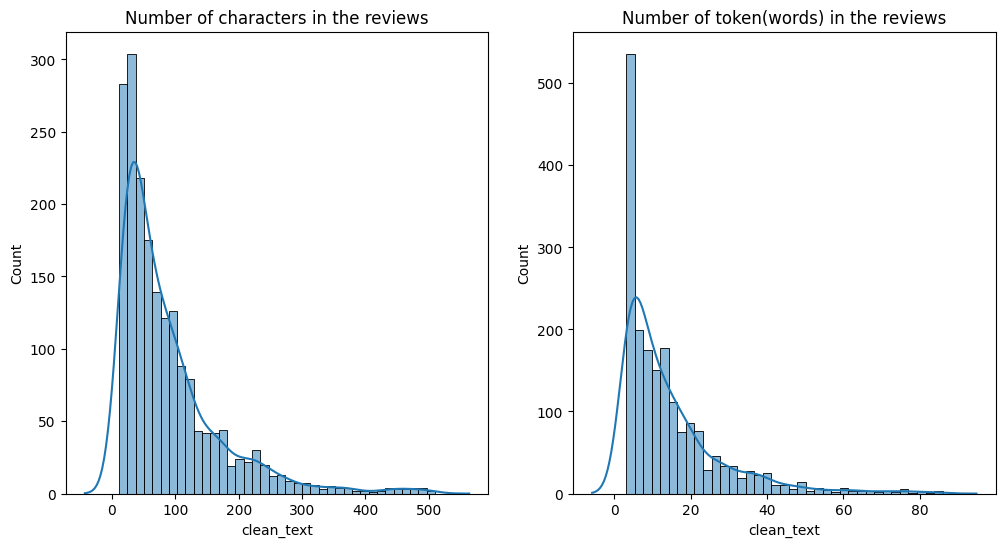

In [68]:
get_text_length(all_df, text_col='clean_text')

## Most Used Word (Unigram)

In [69]:
positive_df = all_df.query("sentiment=='positif'").reset_index(drop=True)
negative_df = all_df.query("sentiment=='negatif'").reset_index(drop=True)

In [70]:
import csv

def visualize_top_words(reviews, top_n=15, color='skyblue', output_file='output'):
    all_reviews = ' '.join(reviews)
    words = all_reviews.split()
    filtered_words = [word for word in words if word not in stopwords.words("indonesian")]
    
    word_counts = Counter(filtered_words)
    word_counts_sw = Counter(words)

    common_words = word_counts.most_common(top_n)
    common_words_sw = word_counts_sw.most_common(top_n)

    words, counts = zip(*common_words)
    words_sw, counts_sw = zip(*common_words_sw)
    
    # Save the top words and counts into a CSV file
#     with open(output_file+".csv", 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow(['Word', 'Count'])
#         for word, count in common_words:
#             writer.writerow([word, count])
#     with open(output_file+"_with_stopword.csv", 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow(['Word (with stopwords)', 'Count'])
#         for word, count in common_words_sw:
#             writer.writerow([word, count])

    # Plot bar chart horizontal
    fig, axs = plt.subplots(1,2, figsize=(15, 7))
    axs[0].barh(words, counts, color=color)
    axs[0].set_xlabel('Frequency')
    axs[0].set_title(f'Top {top_n} Most Frequent Words in Customer Reviews')
    axs[0].invert_yaxis()
    
    axs[1].barh(words_sw, counts_sw, color=color)
    axs[1].set_xlabel('Frequency')
    axs[1].set_title(f'Top {top_n} Most Frequent Words in Customer Reviews (with stopwords)')
    axs[1].invert_yaxis() 
    
    plt.show()

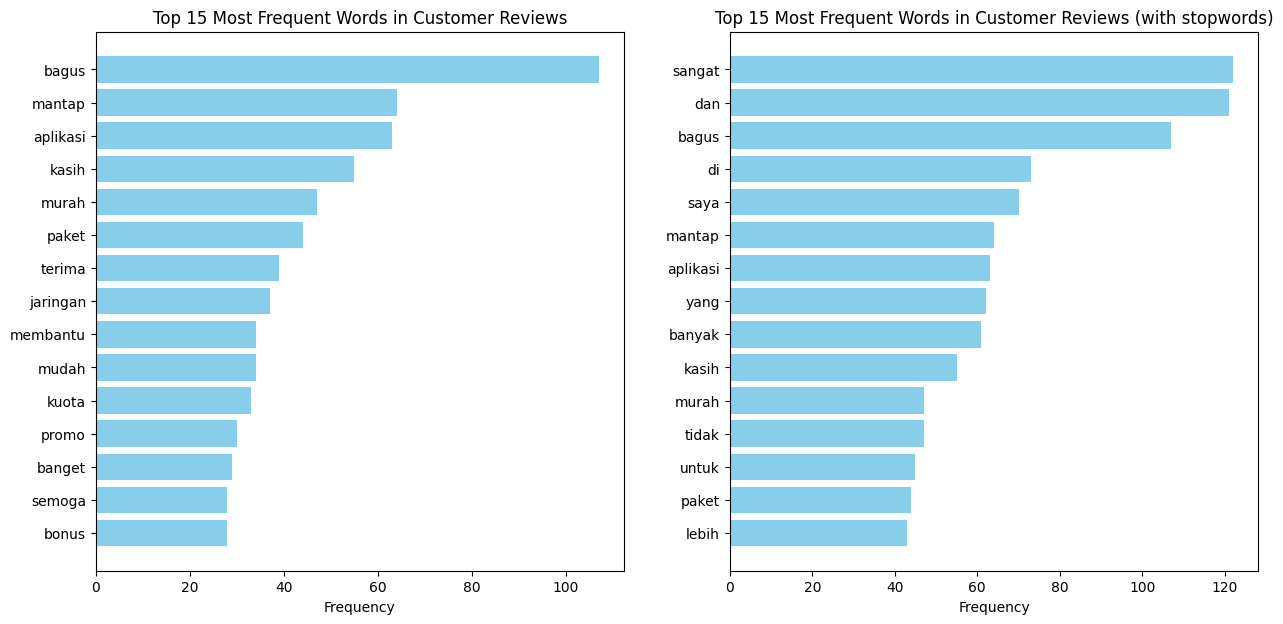

In [71]:
visualize_top_words(positive_df["clean_text"], color='skyblue', output_file="most_popular_positive")

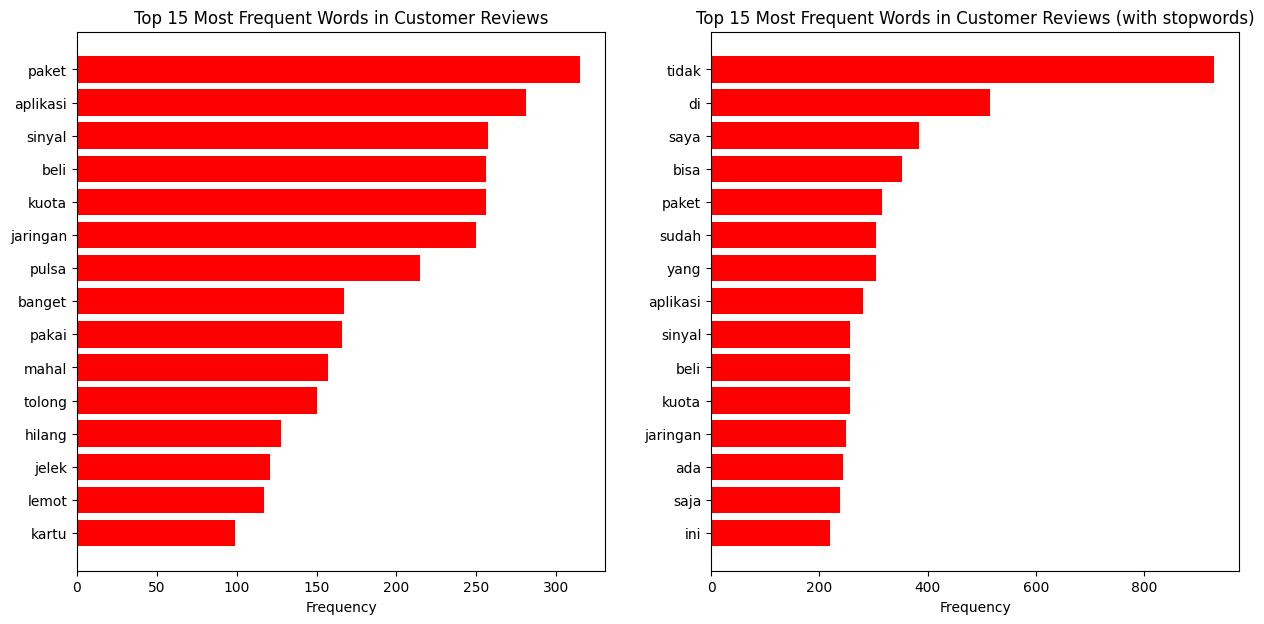

In [72]:
visualize_top_words(negative_df["clean_text"], color='red', output_file="most_popular_neg")

## Most Used Word (Bigram)

In [162]:
from collections import Counter
from nltk.util import ngrams

def visualize_top_bigrams(reviews, top_n=15, color='skyblue', output_file='output'):
    all_reviews = ' '.join(reviews)
    words = all_reviews.split()

    filtered_words = [word for word in words if word not in stopwords.words("indonesian")]
    
    # create bigram
    bigrams = list(ngrams(filtered_words, 2))
    bigrams_sw = list(ngrams(words, 2))

    # count bigram frequency
    bigram_counts = Counter(bigrams)
    bigram_counts_sw = Counter(bigrams_sw)
    
    common_bigrams = bigram_counts.most_common(top_n)
    common_bigrams_sw = bigram_counts_sw.most_common(top_n)

    bigrams, counts = zip(*common_bigrams)
    bigrams_sw, counts_sw = zip(*common_bigrams_sw)

    bigrams = [' '.join(bigram) for bigram in bigrams]
    bigrams_sw = [' '.join(bigram) for bigram in bigrams_sw]
    
    # Save the top words and counts into a CSV file
    with open(output_file+".csv", 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Word', 'Count'])
        for word, count in common_bigrams:
            writer.writerow([word, count])
#     with open(output_file+"_with_stopword.csv", 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow(['Word (with stopwords)', 'w', 'Count'])
#         for word, count in common_bigrams_sw:
#             writer.writerow([word, count])

    # Plot bar chart horizontal
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    axs[0].barh(bigrams, counts, color=color)
    axs[0].set_xlabel('Frequency')
    axs[0].set_title(f'Top {top_n} Most Frequent Bigrams in Customer Reviews')
    axs[0].invert_yaxis()  
    
    axs[1].barh(bigrams_sw, counts_sw, color=color)
    axs[1].set_xlabel('Frequency')
    axs[1].set_title(f'Top {top_n} Most Frequent Bigrams in Customer Reviews (with stopwords)')
    axs[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()

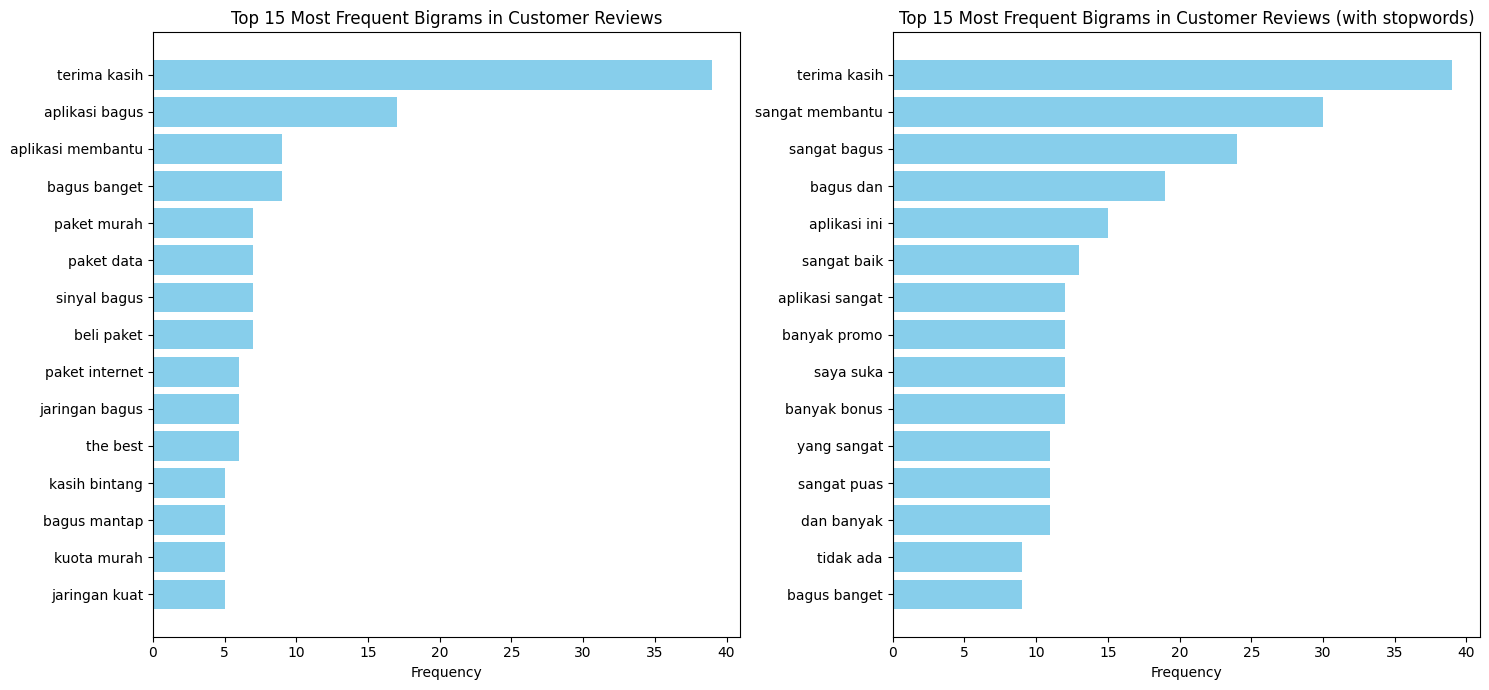

In [163]:
visualize_top_bigrams(
    positive_df["clean_text"], color='skyblue', output_file="most_popular_pos_bigram"
)

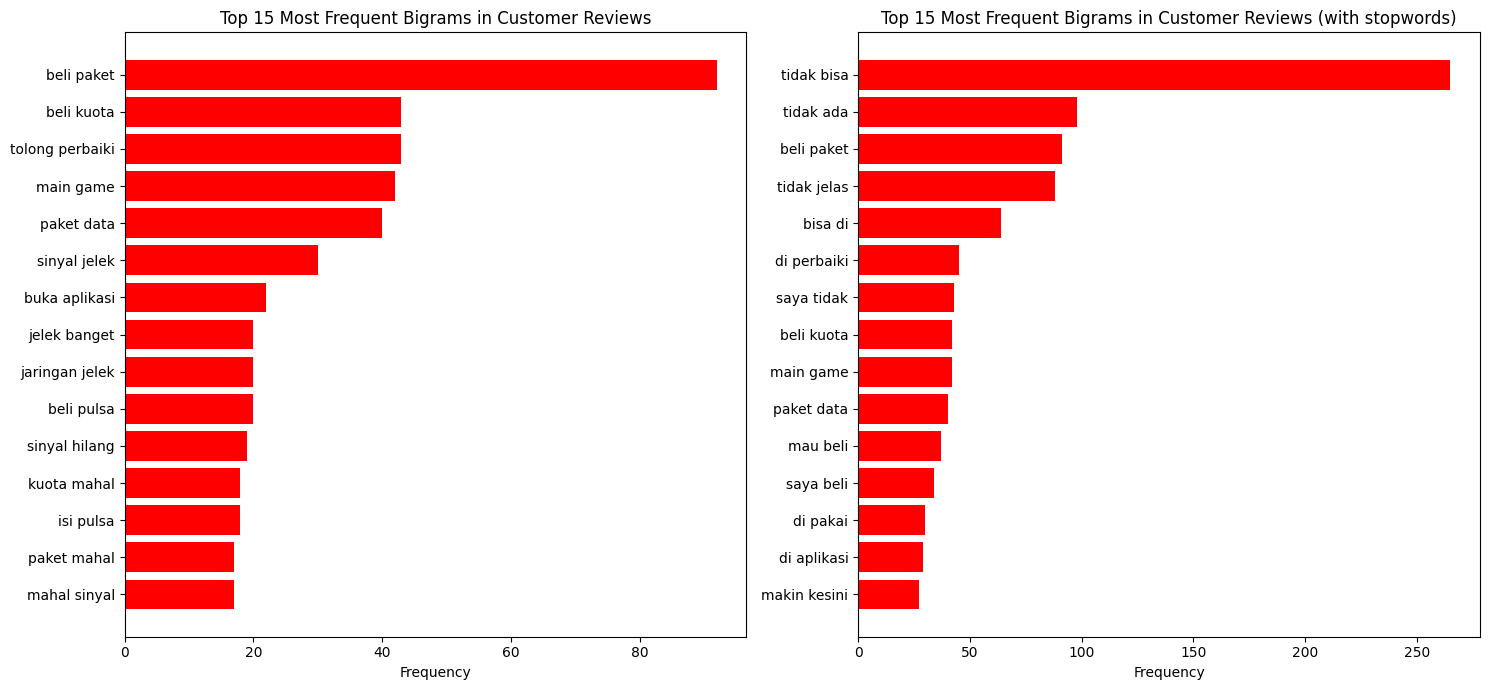

In [164]:
visualize_top_bigrams(
    negative_df["clean_text"], color='red', output_file="most_popular_neg_bigram"
)

## Wordcloud Visualization

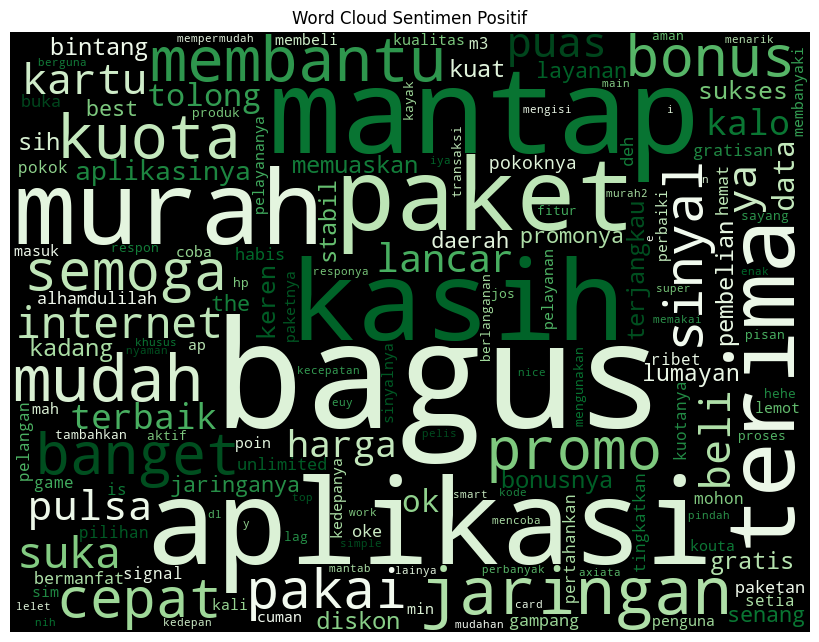

In [76]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
 
stopwords_indo = set(stopwords.words('indonesian'))
comment_words_positive = " ".join(positive_df['clean_text'])

wordcloud = WordCloud(
    width=800, 
    height=600, 
    background_color='black', 
    colormap='Greens',
    stopwords=stopwords_indo,
    min_font_size=10,
    max_font_size=150,
    collocations=False,
    normalize_plurals=False
).generate(comment_words_positive)

                 
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud Sentimen Positif')
 
plt.show()

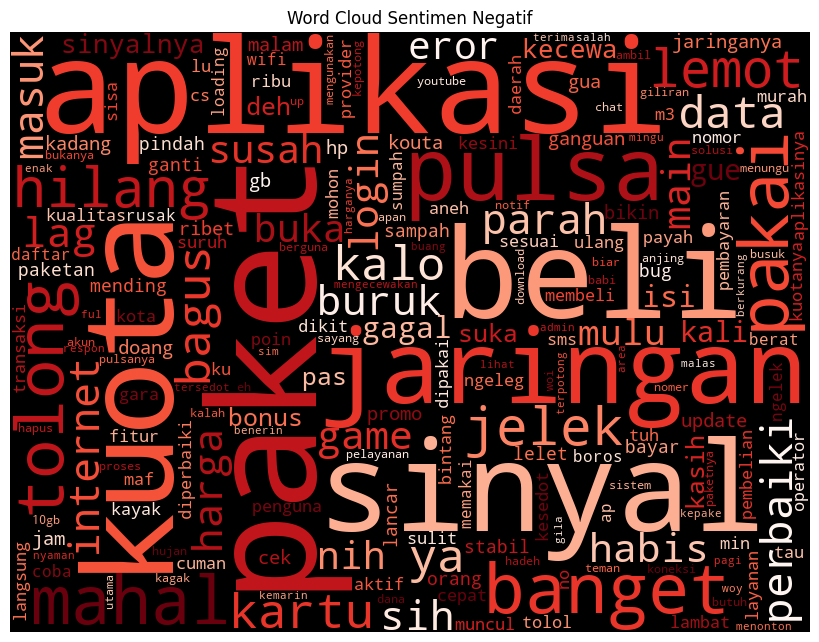

In [77]:
comment_words_negative = " ".join(negative_df['clean_text'])
    
wordcloud = WordCloud(
    width = 800, 
    height = 600, 
    background_color='black', 
    colormap='Reds',
    stopwords=stopwords_indo,
    min_font_size=10,
    max_font_size=150,
    collocations=False,
    normalize_plurals=False
).generate(comment_words_negative)

                 
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Word Cloud Sentimen Negatif')
 
plt.show()

## Visualization for Each Provider

In [78]:
## wordcloud for each provider
telkom_pos = " ".join(positive_df["clean_text"][positive_df["provider"]=="telkomsel"])
xl_pos = " ".join(positive_df["clean_text"][positive_df["provider"]=="xl"])
indosat_pos = " ".join(positive_df["clean_text"][positive_df["provider"]=="indosat"])
smartfren_pos = " ".join(positive_df["clean_text"][positive_df["provider"]=="smartfren"])

telkom_neg = " ".join(negative_df["clean_text"][negative_df["provider"]=="telkomsel"])
xl_neg = " ".join(negative_df["clean_text"][negative_df["provider"]=="xl"])
indosat_neg = " ".join(negative_df["clean_text"][negative_df["provider"]=="indosat"])
smartfren_neg = " ".join(negative_df["clean_text"][negative_df["provider"]=="smartfren"])

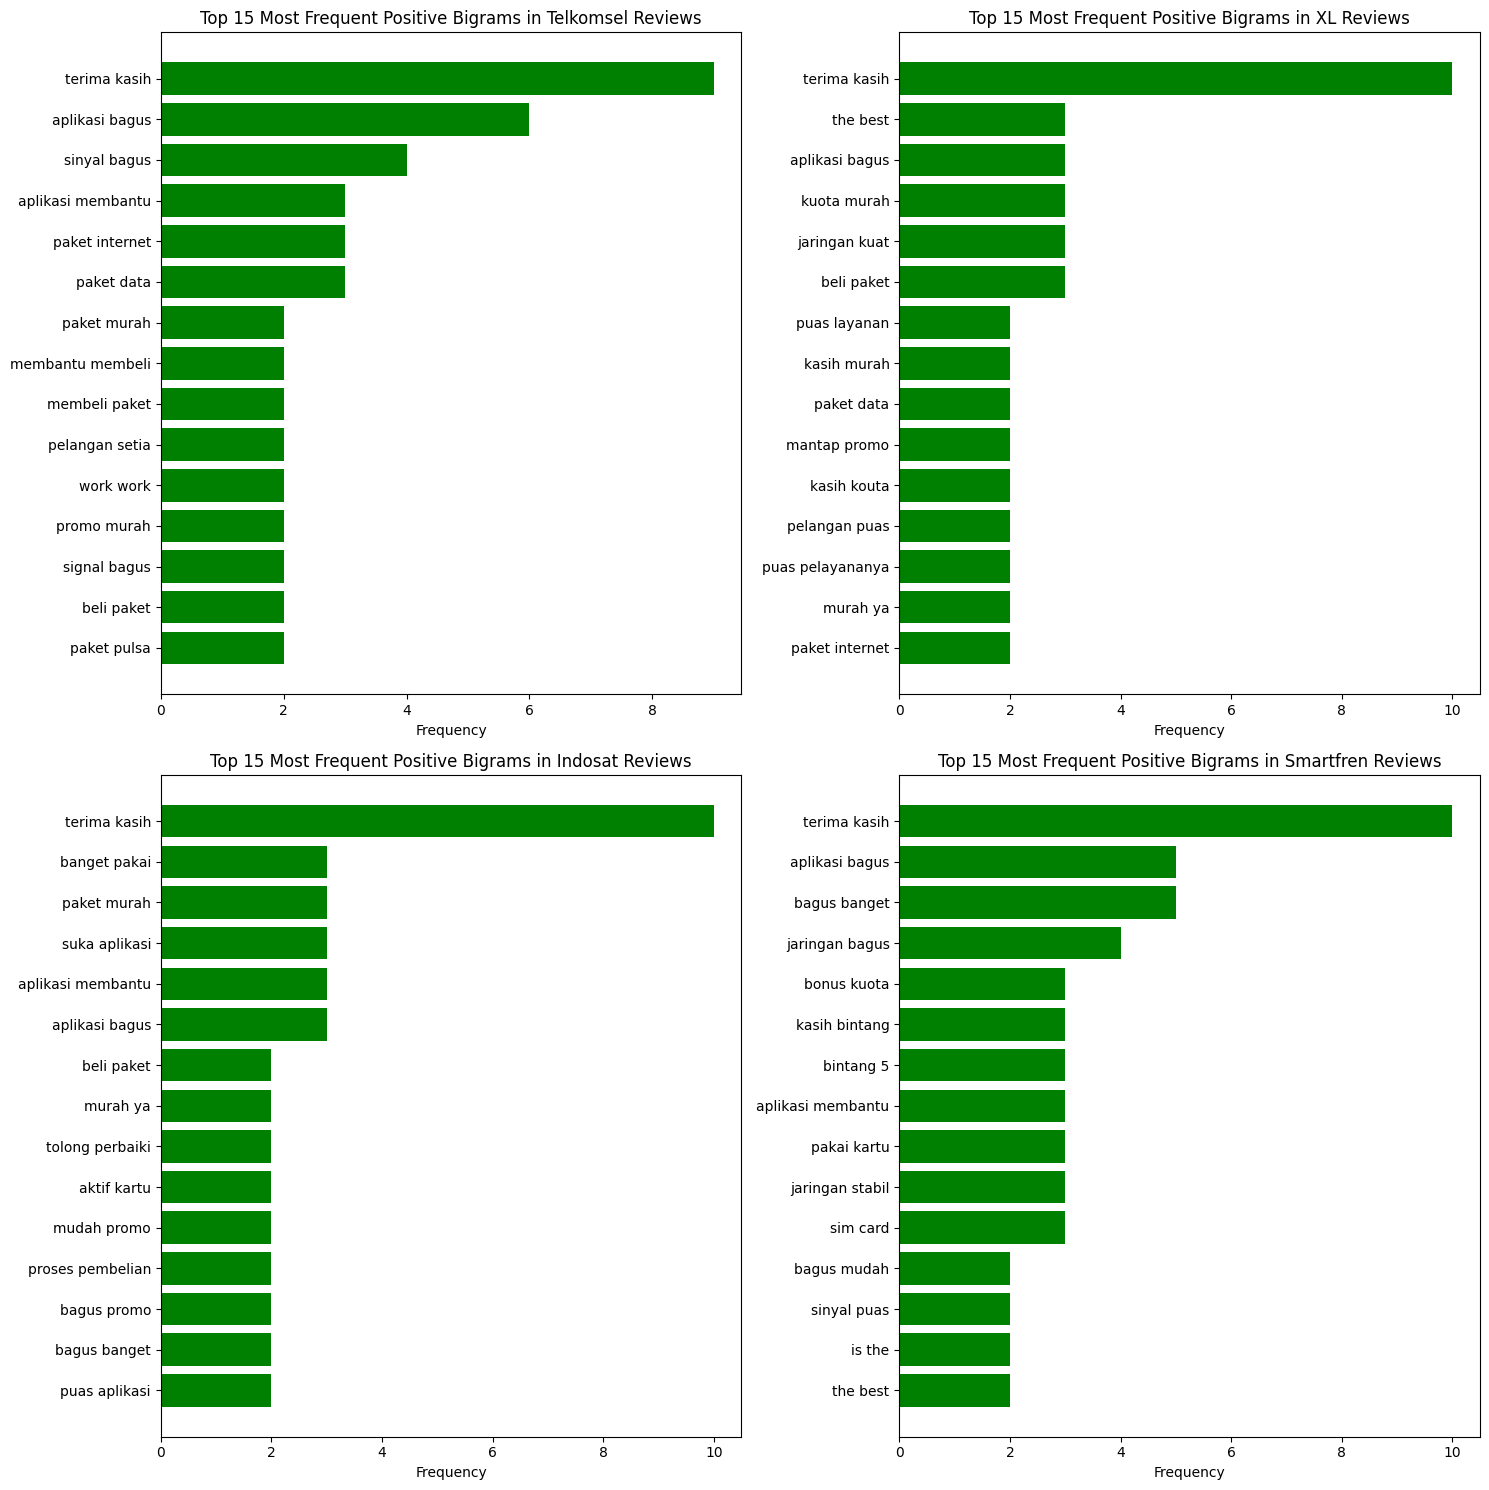

In [165]:
# create bigram
def create_bigram(texts, top_n=15, output_file="output"):
    words = texts.split()
    filtered_words = [word for word in words if word not in stopwords.words("indonesian")]
    bigrams = list(ngrams(filtered_words, 2))
    bigram_counts = Counter(bigrams)
    common_bigrams = bigram_counts.most_common(top_n)
    bigrams, counts = zip(*common_bigrams)
    bigrams = [' '.join(bigram) for bigram in bigrams]
    
    # Save the top words and counts into a CSV file
    with open(output_file+".csv", 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Word', 'Count'])
        for word, count in common_bigrams:
            writer.writerow([word, count])
            
    return bigrams, counts

# Plot bar chart horizontal
top_n = 15
color = "green"
telkom_bigram, telkom_counts = create_bigram(telkom_pos, top_n=top_n, output_file="telkom_pos_bigram")
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs[0,0].barh(telkom_bigram, telkom_counts, color=color)
axs[0,0].set_xlabel('Frequency')
axs[0,0].set_title(f'Top {top_n} Most Frequent Positive Bigrams in Telkomsel Reviews')
axs[0,0].invert_yaxis()  

xl_bigram, xl_counts = create_bigram(xl_pos, top_n=top_n, output_file="xl_pos_bigram")
axs[0,1].barh(xl_bigram, xl_counts, color=color)
axs[0,1].set_xlabel('Frequency')
axs[0,1].set_title(f'Top {top_n} Most Frequent Positive Bigrams in XL Reviews')
axs[0,1].invert_yaxis()

indosat_bigram, indosat_counts = create_bigram(indosat_pos, top_n=top_n, output_file="indosat_pos_bigram")
axs[1,0].barh(indosat_bigram, indosat_counts, color=color)
axs[1,0].set_xlabel('Frequency')
axs[1,0].set_title(f'Top {top_n} Most Frequent Positive Bigrams in Indosat Reviews')
axs[1,0].invert_yaxis()

indosat_bigram, indosat_counts = create_bigram(smartfren_pos, top_n=top_n, output_file="smartfren_pos_bigram")
axs[1,1].barh(indosat_bigram, indosat_counts, color=color)
axs[1,1].set_xlabel('Frequency')
axs[1,1].set_title(f'Top {top_n} Most Frequent Positive Bigrams in Smartfren Reviews')
axs[1,1].invert_yaxis()


plt.tight_layout()
plt.show()

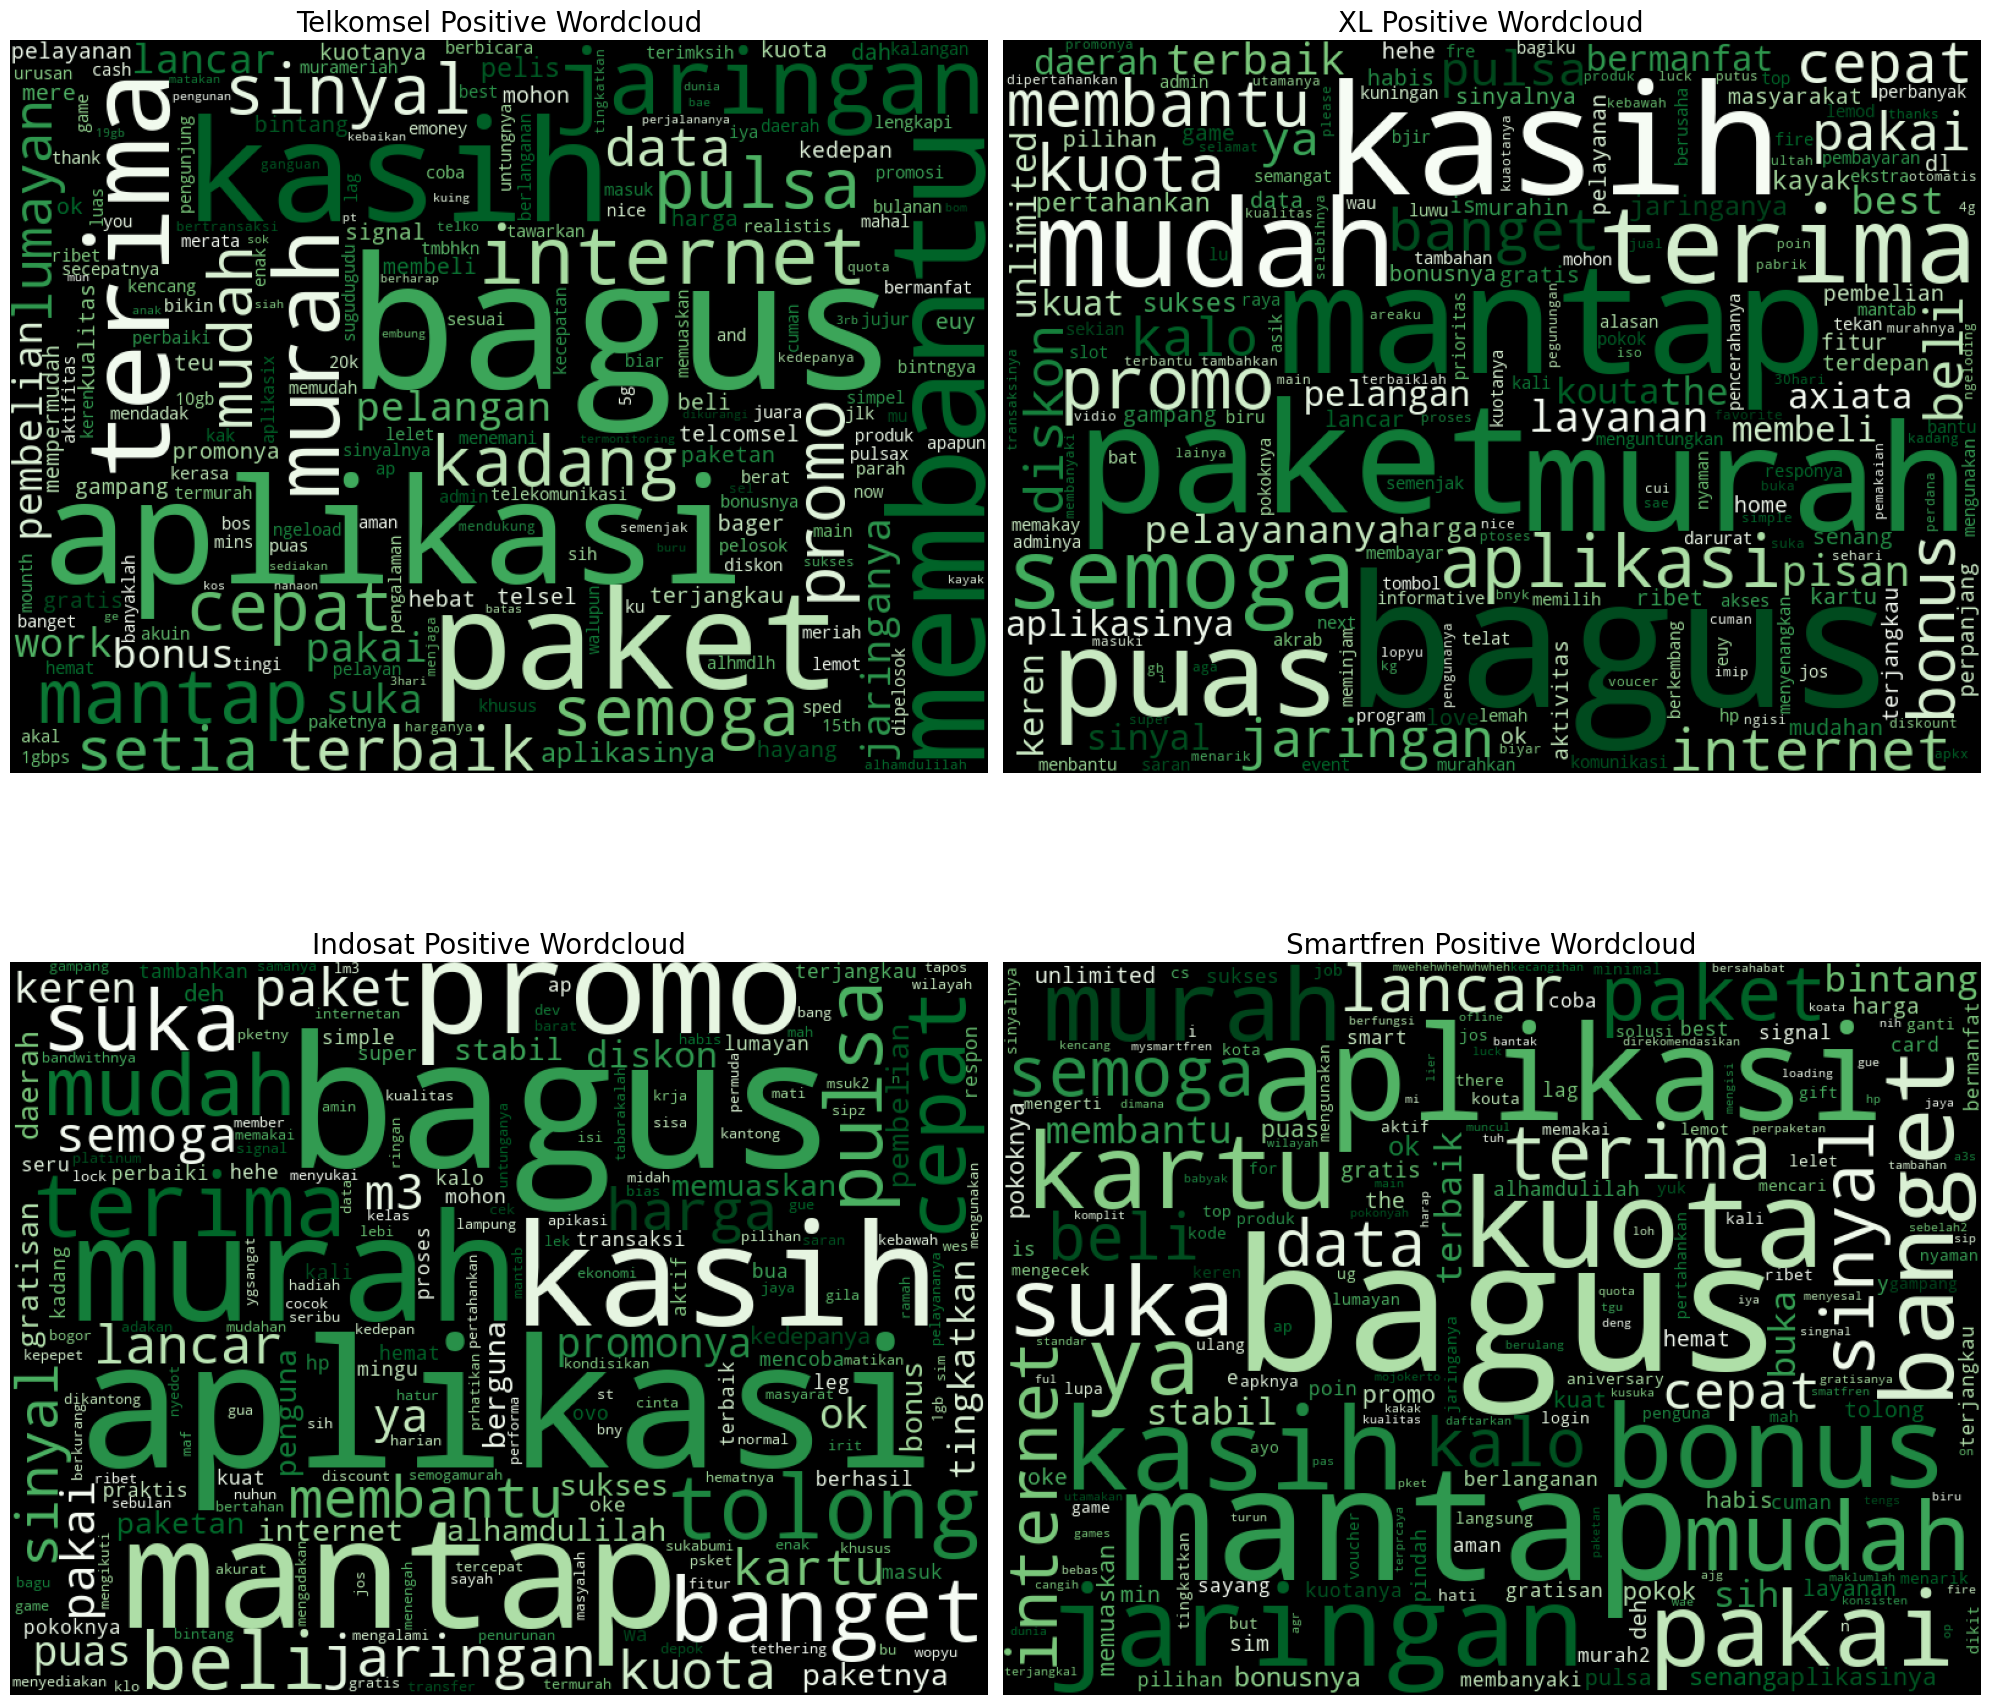

In [79]:
# positive
telkom_pos_wcl = WordCloud(
    width = 800, height = 600, background_color='black', colormap='Greens',stopwords=stopwords_indo,
    min_font_size=10, max_font_size=150, collocations=False, normalize_plurals=False
).generate(telkom_pos)

xl_pos_wcl = WordCloud(
    width = 800, height = 600, background_color='black', colormap='Greens',stopwords=stopwords_indo,
    min_font_size=10, max_font_size=150,collocations=False, normalize_plurals=False
).generate(xl_pos)

indosat_pos_wcl = WordCloud(
    width = 800, height = 600, background_color='black', colormap='Greens', stopwords=stopwords_indo,
    min_font_size=10, max_font_size=150, collocations=False, normalize_plurals=False
).generate(indosat_pos)

smartfren_pos_wcl = WordCloud(
    width = 800, height = 600, background_color='black', colormap='Greens', stopwords=stopwords_indo,
    min_font_size=10, max_font_size=150, collocations=False, normalize_plurals=False
).generate(smartfren_pos)

# Plotting the WordCloud images                     
plt.figure(figsize=(20, 20), facecolor = None)

plt.subplot(2, 2, 1)
plt.imshow(telkom_pos_wcl)
plt.axis("off")
plt.title('Telkomsel Positive Wordcloud', fontdict={'fontsize': 20})

plt.subplot(2, 2, 2)
plt.imshow(xl_pos_wcl)
plt.axis("off")
plt.title('XL Positive Wordcloud', fontdict={'fontsize': 20})

plt.subplot(2, 2, 3)
plt.imshow(indosat_pos_wcl)
plt.axis("off")
plt.title('Indosat Positive Wordcloud', fontdict={'fontsize': 20})

plt.subplot(2, 2, 4)
plt.imshow(smartfren_pos_wcl)
plt.axis("off")
plt.title('Smartfren Positive Wordcloud', fontdict={'fontsize': 20})

plt.tight_layout() 
plt.show()

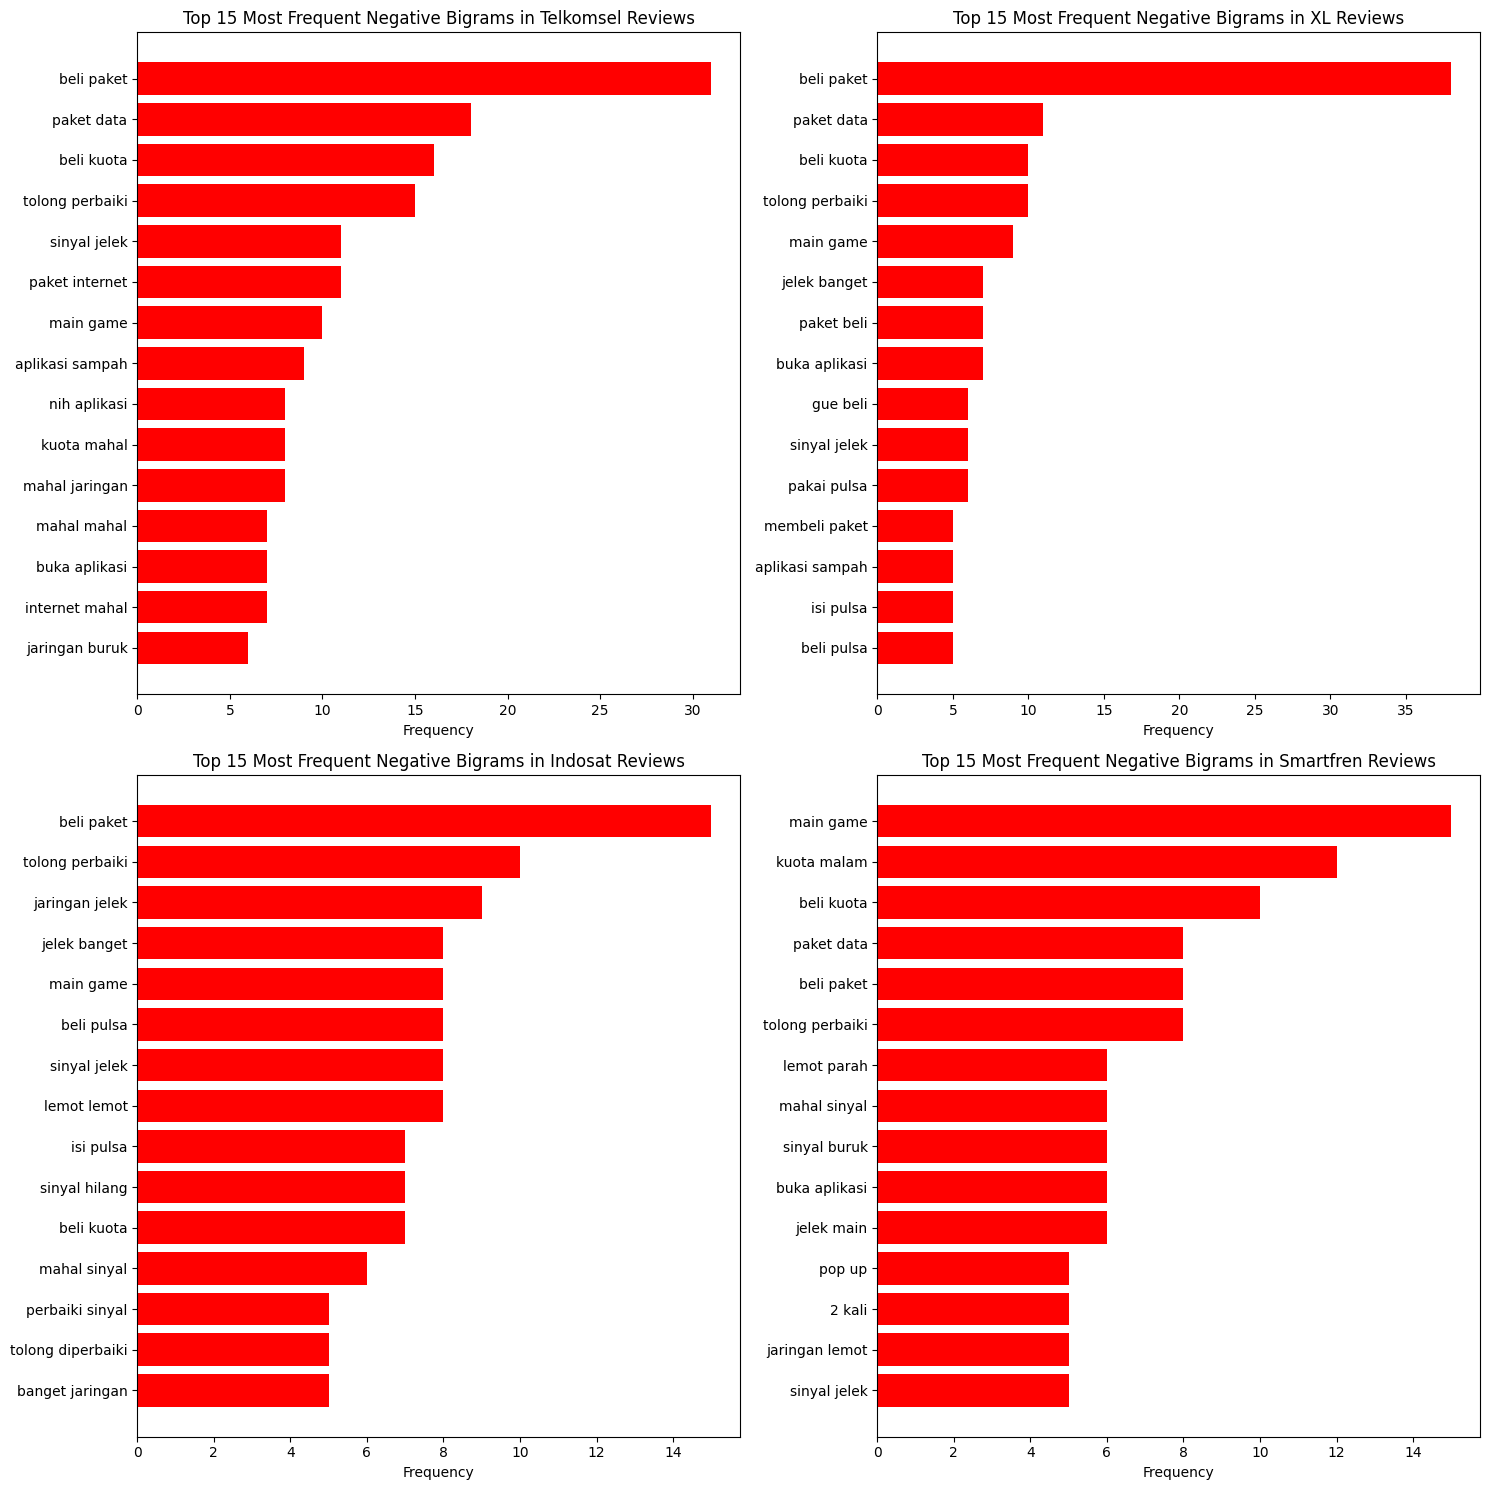

In [166]:
# Plot bar chart horizontal
top_n = 15
color = "red"
telkom_bigram, telkom_counts = create_bigram(telkom_neg, top_n=top_n, output_file="telkom_neg_bigram")
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs[0,0].barh(telkom_bigram, telkom_counts, color=color)
axs[0,0].set_xlabel('Frequency')
axs[0,0].set_title(f'Top {top_n} Most Frequent Negative Bigrams in Telkomsel Reviews')
axs[0,0].invert_yaxis()  

xl_bigram, xl_counts = create_bigram(xl_neg, top_n=top_n, output_file="xl_neg_bigram")
axs[0,1].barh(xl_bigram, xl_counts, color=color)
axs[0,1].set_xlabel('Frequency')
axs[0,1].set_title(f'Top {top_n} Most Frequent Negative Bigrams in XL Reviews')
axs[0,1].invert_yaxis()

indosat_bigram, indosat_counts = create_bigram(indosat_neg, top_n=top_n, output_file="indosat_neg_bigram")
axs[1,0].barh(indosat_bigram, indosat_counts, color=color)
axs[1,0].set_xlabel('Frequency')
axs[1,0].set_title(f'Top {top_n} Most Frequent Negative Bigrams in Indosat Reviews')
axs[1,0].invert_yaxis()

indosat_bigram, indosat_counts = create_bigram(smartfren_neg, top_n=top_n, output_file="smartfren_neg_bigram")
axs[1,1].barh(indosat_bigram, indosat_counts, color=color)
axs[1,1].set_xlabel('Frequency')
axs[1,1].set_title(f'Top {top_n} Most Frequent Negative Bigrams in Smartfren Reviews')
axs[1,1].invert_yaxis()


plt.tight_layout()
plt.show()

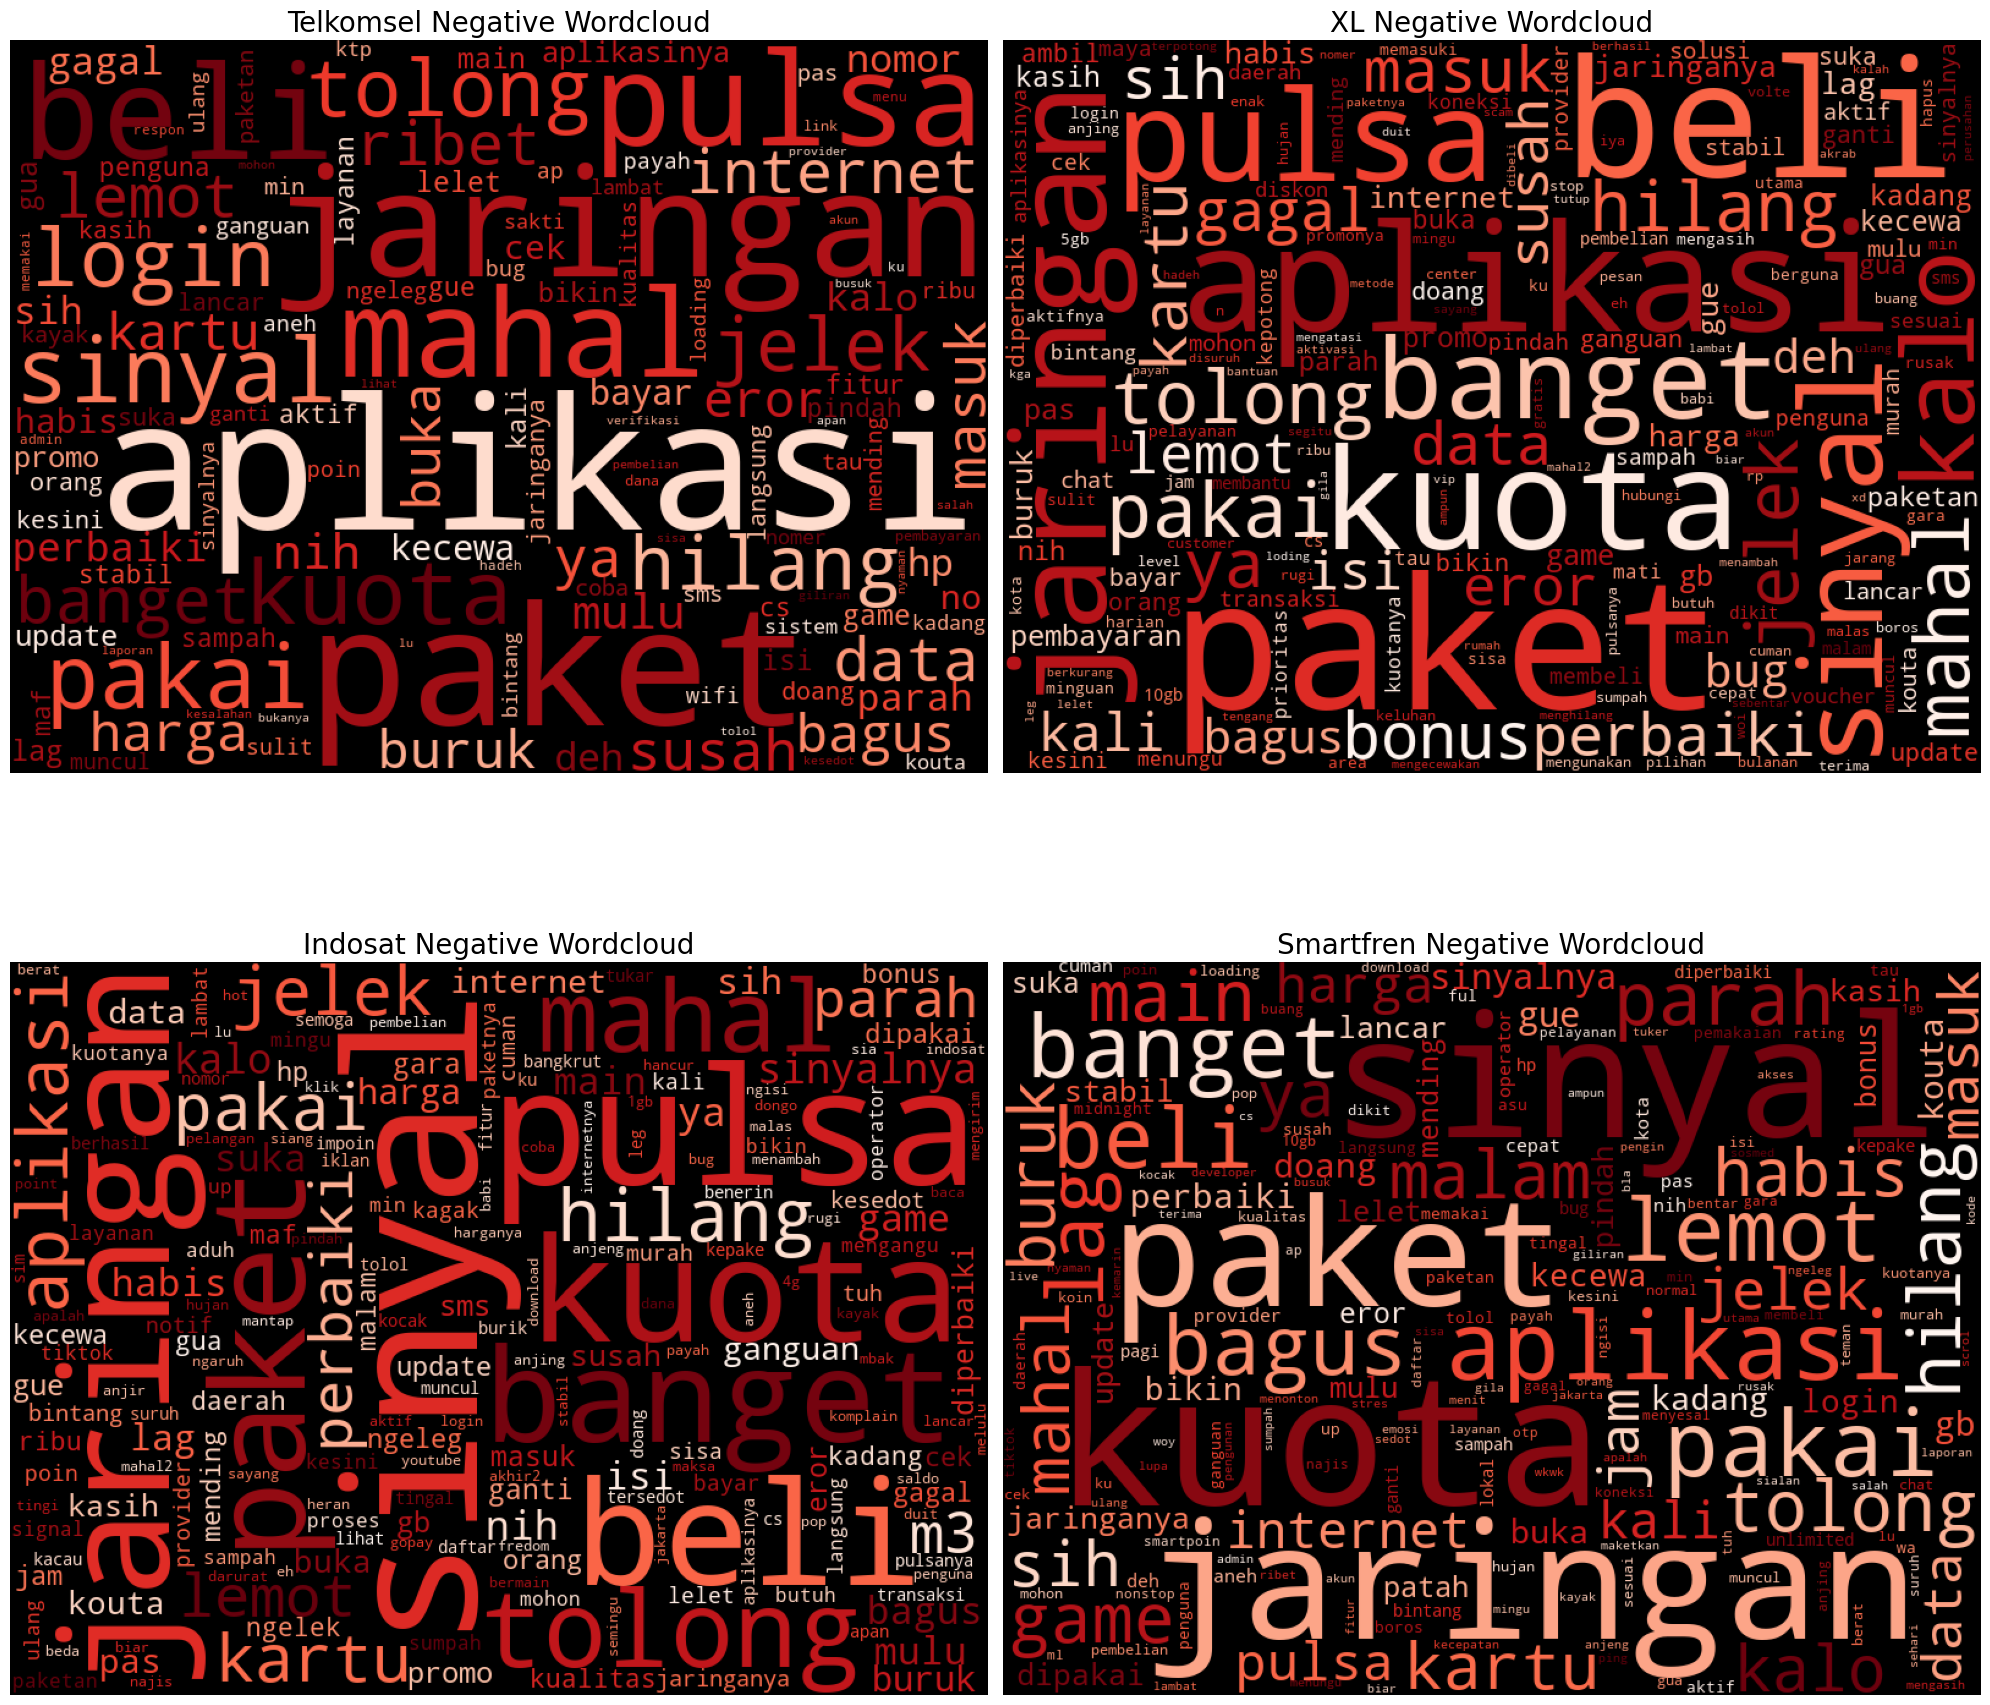

In [80]:
# positive
telkom_neg_wcl = WordCloud(
    width = 800, height = 600, background_color='black', colormap='Reds',stopwords=stopwords_indo,
    min_font_size=10, max_font_size=150, collocations=False, normalize_plurals=False
).generate(telkom_neg)

xl_neg_wcl = WordCloud(
    width = 800, height = 600, background_color='black', colormap='Reds',stopwords=stopwords_indo,
    min_font_size=10, max_font_size=150,collocations=False, normalize_plurals=False
).generate(xl_neg)

indosat_neg_wcl = WordCloud(
    width = 800, height = 600, background_color='black', colormap='Reds', stopwords=stopwords_indo,
    min_font_size=10, max_font_size=150, collocations=False, normalize_plurals=False
).generate(indosat_neg)

smartfren_neg_wcl = WordCloud(
    width = 800, height = 600, background_color='black', colormap='Reds', stopwords=stopwords_indo,
    min_font_size=10, max_font_size=150, collocations=False, normalize_plurals=False
).generate(smartfren_neg)

# Plotting the WordCloud images                     
plt.figure(figsize=(20, 20), facecolor = None)

plt.subplot(2, 2, 1)
plt.imshow(telkom_neg_wcl)
plt.axis("off")
plt.title('Telkomsel Negative Wordcloud', fontdict={'fontsize': 20})

plt.subplot(2, 2, 2)
plt.imshow(xl_neg_wcl)
plt.axis("off")
plt.title('XL Negative Wordcloud', fontdict={'fontsize': 20})

plt.subplot(2, 2, 3)
plt.imshow(indosat_neg_wcl)
plt.axis("off")
plt.title('Indosat Negative Wordcloud', fontdict={'fontsize': 20})

plt.subplot(2, 2, 4)
plt.imshow(smartfren_neg_wcl)
plt.axis("off")
plt.title('Smartfren Negative Wordcloud', fontdict={'fontsize': 20})

plt.tight_layout() 
plt.show()

# Modelling

In [89]:
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score

In [90]:
# split data
X = all_df["clean_text"]
y = all_df["sentiment"]

def encode_label(label):
    if label == 'positif':
        return 1
    else:
        return 0

y = y.apply(lambda x: encode_label(x))

train_df, X_test, train_label, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(train_df, train_label, test_size=0.2, random_state=0)

In [117]:
print(f"Train-val data size: {len(train_df)}")
print(f"Train data size: {len(X_train)}")
print(f"Validation data label: {len(X_val)}")
print(f"Test data size: {len(X_test)}")

Train-val data size: 1724
Train data size: 1379
Validation data label: 345
Test data size: 192


## SKlearn Machine Learning

In [118]:
def train_model(model, X_train, y_train, X_test, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=0)

    # Create and train model
    trained_model = Pipeline([
        ('word_embedding', TfidfVectorizer()),
        ('classification_model', model)
    ])

    f1_score = cross_val_score(trained_model, X_train, y_train, cv=kfold, scoring='f1')
    precision_score = cross_val_score(trained_model, X_train, y_train, cv=kfold, scoring='precision')
    recall_score = cross_val_score(trained_model, X_train, y_train, cv=kfold, scoring='recall')
    
    scores = {
        "F1-score": f1_score,
        "Precision": precision_score,
        "Recall": recall_score
    }
    
    # Create a DataFrame for F1 scores of each fold
    f1_df = pd.DataFrame(scores, 
                         index=[f"fold_{fold+1}" for fold in range(n_splits)])
    
    avg_scores = {
        "F1-score":np.mean(f1_score),
        "Precision": np.mean(precision_score),
        "Recall": np.mean(recall_score)
    }
    # Calculate the average F1-score
    avg_score = pd.DataFrame([avg_scores], 
                             index=["avg_score"])
    
    # Concatenate the F1 scores and the average score
    f1_df = pd.concat([f1_df, avg_score])
    
    # fit the data and calculate score on test set
    trained_model.fit(X_train, y_train)
    y_pred = trained_model.predict(X_test)
    
    return f1_df, y_pred

In [119]:
svc = SVC()
trained_model_svc, y_pred = train_model(svc, train_df, train_label, X_test, n_splits=5)
trained_model_svc

F1-score  Precision    Recall
fold_1     0.834286   0.960526  0.737374
fold_2     0.791045   0.898305  0.706667
fold_3     0.865672   0.966667  0.783784
fold_4     0.813953   0.945946  0.714286
fold_5     0.811429   0.946667  0.710000
avg_score  0.823277   0.943622  0.730422

In [120]:
svm_score = f1_score(y_test, y_pred)
print(f"Prediction score on test data: {svm_score*100:.2f} %")

Prediction score on test data: 84.78 %


### Hyperparameter Tuning

In [121]:
## hyperparameter tuning using GridSearch method with 5 kfold cross-validation
from sklearn.model_selection import GridSearchCV

kfold = KFold(n_splits=5, shuffle=True, random_state=0)
params = {
        'clf_model__C': [0.1, 1, 10, 100, 1000],  
        'clf_model__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
        'clf_model__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
    }
# Create and train model
trained_model = Pipeline([
    ('word_embedding', TfidfVectorizer()),
    ('clf_model', svc)
])

grid_search = GridSearchCV(estimator=trained_model,  
                           param_grid=params,
                           scoring='f1',
                           cv=kfold,
                           verbose=1) 

grid_search.fit(train_df, train_label)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('word_embedding', TfidfVectorizer()),
                                       ('clf_model', SVC())]),
             param_grid={'clf_model__C': [0.1, 1, 10, 100, 1000],
                         'clf_model__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'clf_model__kernel': ['linear', 'rbf', 'poly',
                                               'sigmoid']},
             scoring='f1', verbose=1)

In [122]:
# best score achieved during the GridSearchCV
print(f'GridSearch CV best score : {grid_search.best_score_*100:.2f} %\n')
# print parameters that give the best results
print(f'Parameters that give the best results :\n{grid_search.best_params_}\n')
# print estimator that was chosen by the GridSearch
print(f'\nEstimator that was chosen by the search :\n{grid_search.best_estimator_}\n')

GridSearch CV best score : 84.93 %

Parameters that give the best results :
{'clf_model__C': 1, 'clf_model__gamma': 1, 'clf_model__kernel': 'sigmoid'}


Estimator that was chosen by the search :
Pipeline(steps=[('word_embedding', TfidfVectorizer()),
                ('clf_model', SVC(C=1, gamma=1, kernel='sigmoid'))])



In [ ]:
# score_gs = cross_val_score(grid_search, X_train, y_train, cv=kfold, scoring='f1')
# print(f"Cross-validation score:\n{score_gs}")

# print(f"Cross-validation score:\n{np.mean(score_gs)*100:.2f}")

In [123]:
# predict test set using gridsearch model
y_pred_gs = grid_search.best_estimator_.predict(X_test)

# show prediction score
svm_gs_score = f1_score(y_test, y_pred_gs)
print(f"Prediction score on test data: {svm_gs_score*100:.2f} %")

Prediction score on test data: 87.23 %


In [124]:
import joblib

joblib.dump(grid_search, 'svm_grid_search.pkl')

['svm_grid_search.pkl']

In [125]:
def mismatched_pred(df, gt_col, pred_col):
    """ Filters the DataFrame rows where the prediction does not match the true label.
    
    Args:
        df: pandas DataFrame containing the prediction and true label columns.
        gt_col: name of the column containing the true labels.
        pred_col: name of the column containing the predicted labels.
    
    Returns:
        DataFrame containing only the rows where prediction != true label.
    """
    # Filter rows where the true label is not equal to the prediction
    mismatches = df[df[gt_col] != df[pred_col]]
    
    return mismatches

test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)
test_df["prediction"] = y_pred
mismatched_pred(test_df, "sentiment", "prediction")

clean_text  sentiment  prediction
465   refresh beranda saja hampir 50mnt pelayan cs a...          0           1
1023                                 gampang di gunakan          1           0
1651                            banyak bonusan thankyou          1           0
1672                           banyak poin bisa dipakai          1           0
1554                          kalo ada bebas wilayah ya          1           0
711   saya sudah membayar pulsa darurat saya ketika ...          1           0
789       murah banget bisa di perpanjang otomatis lagi          1           0
597                                  sering dapat bonus          1           0
1492                                  memang paling top          1           0
1497  aniversary gift kapan ada aku harap ada tambah...          1           0
1601                              bagus tapi agak lemot          0           1
1845                               di jamin murah2 gaes          1           0
1585                               saya mau kuota 10 gb          1           0
473   hayang kuota gratis euy pelis dah bager mun te...          1           0

Text(0.5, 23.52222222222222, 'Prediction')

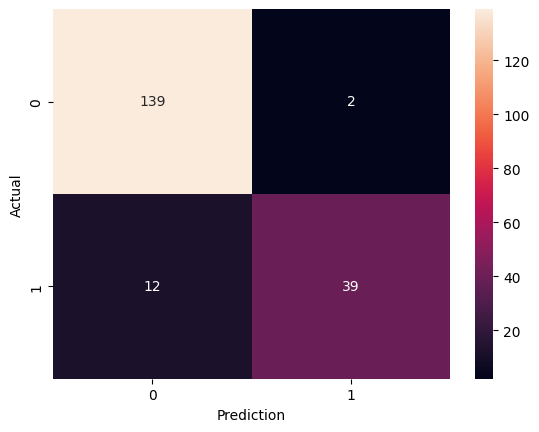

In [126]:
sns.heatmap(
    confusion_matrix(
        test_df['sentiment'], 
        test_df['prediction']
    ), 
    annot=True, 
    fmt='g'
)
plt.ylabel('Actual')
plt.xlabel('Prediction')

First test data evaluation before relabeling (test data 5%)

legend:
- checklist: will be relabeled
- 0: wrong detection
- x: no meaning
- <->: no idea
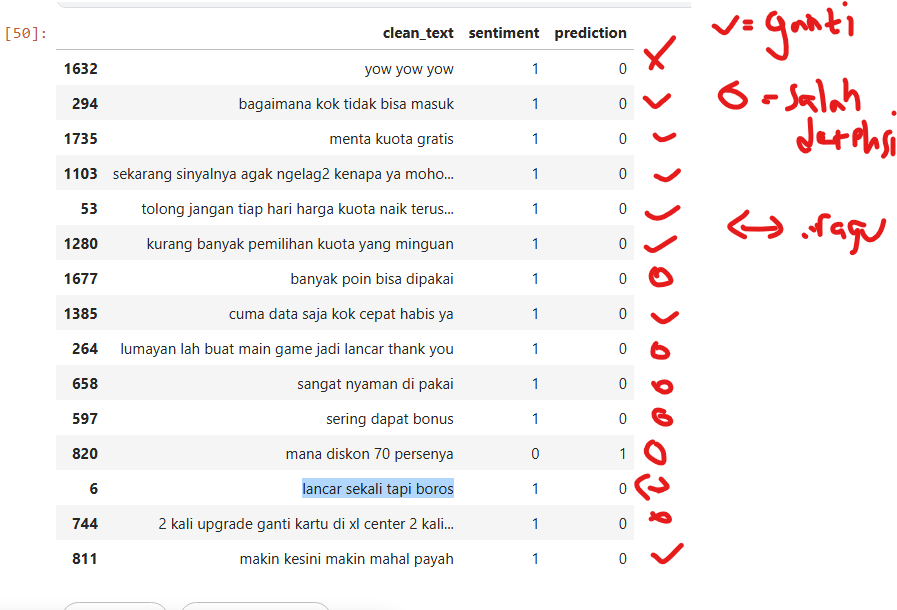

second test data (test data 10%, including previous test) (~75% F1-score)
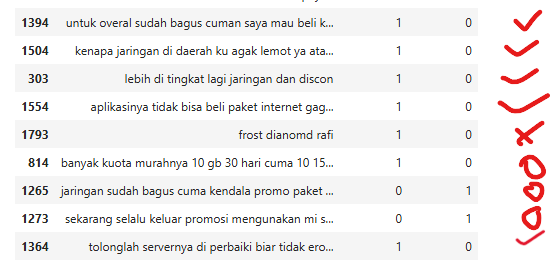

Third test:
- average training score: 0.817845
- GridSearch CV best score : 0.8485
- test data prediction score: 85.47 %

## LSTM

In [101]:
## importing modules
import random
import collections

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
# from tensorflow.keras.metrics import F1Score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchmetrics.classification import BinaryF1Score

# import torchtext
# from torchtext import data
# from torchtext.data.utils import get_tokenizer
# from torchtext import vocab

In [102]:
all_df = pd.read_csv("/kaggle/working/preprocessed_df_ft.csv")

# split data
X = all_df["clean_text"]
y = all_df["sentiment"]

def encode_label(label):
    if label == 'positif':
        return 1
    else:
        return 0

y = y.apply(lambda x: encode_label(x))

train_df, X_test, train_label, y_test = train_test_split(
    X, y, test_size=0.1, random_state=0
)
X_train, X_val, y_train, y_val = train_test_split(
    train_df, train_label, test_size=0.2, random_state=0
)

In [103]:
## DEEP LEARNING PREPROCESSING
# Parameters for padding and OOV tokens
trunc_type='pre'
max_length = 200
padding_type='pre'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Generate and pad the training sequences
train_seq = tokenizer.texts_to_sequences(X_train)
train_pad = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the validation sequences
val_seq = tokenizer.texts_to_sequences(X_val)
val_pad = pad_sequences(val_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the test sequences
test_seq = tokenizer.texts_to_sequences(X_test)
test_pad = pad_sequences(test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
train_labels = np.array(y_train)
val_labels = np.array(y_val)
test_labels = np.array(y_test)


# personal note: PyTorch accept padding and truncating 'pre', it cannot learn 'post' pad and trunc
# gained low metric score and don't update, unless there's special method to learn from 'post'

In [104]:
# building a vocab
vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 2918


In [105]:
# create a review class to show len and item.
class ReviewDataset(Dataset):
    def __init__(self ,text, sentiment):
        self.text = text
        self.sentiment = sentiment
        
    def __len__(self):
        return len(self.text)

    def __getitem__(self,item):
        text = self.text[item]
        target = self.sentiment[item]
        return {
            "text": torch.tensor(text, dtype=torch.long),
            "label": torch.tensor(target, dtype=torch.long)
        }

In [106]:
# apply review class to data
train_data = ReviewDataset(text=train_pad, sentiment=train_labels)
val_data = ReviewDataset(text=val_pad, sentiment=val_labels)
test_data = ReviewDataset(text=test_pad, sentiment=test_labels)

# create dataloader
batch_size = 64

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [107]:
# obtain one batch of training data
one_batch = next(iter(train_loader))

print(f'Sample input size: {one_batch["text"].size()}')
print(f'Sample input: \n{one_batch["text"]}')
print(f'Sample input: \n{one_batch["label"]}')

Sample input size: torch.Size([64, 200])
Sample input: 
tensor([[   0,    0,    0,  ...,    6,    2,  266],
        [   0,    0,    0,  ...,   72,   47,   16],
        [   0,    0,    0,  ...,  133,  116,   57],
        ...,
        [   0,    0,    0,  ...,  218,   77,  276],
        [   0,    0,    0,  ...,  207,   81,  429],
        [   0,    0,    0,  ...,   38, 1935,  165]])
Sample input: 
tensor([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0])


In [108]:
class LSTMModel(nn.Module):
    def __init__(self, 
                 vocab_size: int, 
                 n_layers: int, 
                 hidden_dim: int, 
                 output_size: int, 
                 embedding_matrix=None,
                 embedding_dim=None,
                 use_pretrained: bool=True
                ):
        super(LSTMModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_matrix = embedding_matrix
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.use_pretrained = use_pretrained
        
        # Define the embedding layer dimensions
        if use_pretrained:
            num_words = self.embedding_matrix.shape[0]
            embedd_dim = self.embedding_matrix.shape[1]
        else:
            # Define embedding dimensions if no pretrained weights are used
            num_words = vocab_size
            embedd_dim = embedding_dim
        
        self.embedding = nn.Embedding(num_embeddings=num_words, embedding_dim=embedd_dim)
        
        if use_pretrained:
            # initialize embedding layer's weights to pretrained embedding in embedding matrix
            self.embedding.weight = nn.Parameter(
                torch.tensor(embedding_matrix, dtype=torch.float32)
            )
            # Freeze embedding weights if using pretrained embeddings
            self.embedding.weight.requires_grad = False
        
        self.lstm = nn.LSTM(
            input_size=embedd_dim, hidden_size=self.hidden_dim, 
            bidirectional=True, num_layers=self.n_layers, 
            batch_first=True
        )
        
        self.dropout = nn.Dropout(0.5)
        
        self.fc = nn.Linear(in_features=hidden_dim*2, out_features=output_size)
        
    def forward(self, x):
        embedd = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(embedd)
#         print(f"{lstm_out.size()}")  torch.Size([128, 300, 128])
        out = self.dropout(lstm_out)
        out = out[:, -1]
#         print(f"{out.size()}") torch.Size([128, 128])
        out = self.fc(out)
#         print(f"{out.size()}") torch.Size([128, 1])
    
        return out

### Without pretrained Word Embedding

In [109]:
max_length = 200
batch_size = 64
hidden_dim = 64
output_size = 1
embedding_dim = 200
vocab_size = len(tokenizer.index_word) + 1
n_layers = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}\n")

model = LSTMModel(
    vocab_size=vocab_size, embedding_dim=embedding_dim, n_layers=n_layers, 
    hidden_dim=hidden_dim, output_size=output_size, use_pretrained=False
)
model = model.to(device)
print(model)

Device: cuda

LSTMModel(
  (embedding): Embedding(2918, 200)
  (lstm): LSTM(200, 64, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [110]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        # applied xavier weigth initialization on linear layer 
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "bias" in name:
                nn.init.zeros_(param)
            elif "weight" in name:
                # Orthogonal initialization helps maintain 
                # the norm of the gradient during backpropagation
                nn.init.orthogonal_(param)

model.apply(initialize_weights)

LSTMModel(
  (embedding): Embedding(2918, 200)
  (lstm): LSTM(200, 64, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [111]:
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

class EarlyStopper:
    # https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
    def __init__(self, patience=2, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss - self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [112]:
def train_step(dataloader: torch.utils.data.DataLoader, 
               model: torch.nn.Module, 
               criterion: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    model.train()
    
    train_loss = []
    train_f1score = []
    metricf1 = BinaryF1Score().to(device)
    
    for i, data in enumerate(tqdm(dataloader, desc="Training...")):
        
        inputs = data['text'].to(device)
        labels = data['label'].to(device, dtype=torch.float) 
        
        # forward pass
        logits = model(inputs)
        
        # calculate loss and f1 score
        loss = criterion(logits.squeeze(), labels)
        probs = F.sigmoid(logits.squeeze())
        score = metricf1(probs, labels)
        
        # optimize zero grad
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        
        #`clip_grad_norm` helps prevent the exploding gradient problem in LSTMs
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        
        # optimizer step (update weight/params)
        optimizer.step()
        
        train_loss.append(loss.item())
        train_f1score.append(score.cpu())
    
    return np.mean(train_loss), np.mean(train_f1score)

def validation_step(dataloader: torch.utils.data.DataLoader, 
                    model: torch.nn.Module, 
                    criterion: torch.nn.Module, 
                    device: torch.device = device):
    model.eval()
    
    val_loss = []
    val_f1score = []
    metricf1 = BinaryF1Score().to(device)
    
    with torch.inference_mode():
        for i, data in enumerate(tqdm(dataloader, desc="Validating...")):
            inputs = data['text'].to(device)
            labels = data['label'].to(device, dtype=torch.float) 
            
            logits = model(inputs)
            
            loss = criterion(logits.squeeze(), labels)
            probs = F.sigmoid(logits.squeeze())
            score = metricf1(probs, labels)
            
            val_loss.append(loss.item())
            val_f1score.append(score.cpu())
    
    return np.mean(val_loss), np.mean(val_f1score)

In [113]:
def training(train_dataloader: torch.utils.data.DataLoader,
             val_dataloader: torch.utils.data.DataLoader,
             model: torch.nn.Module,
             optimizer: torch.optim.Optimizer, 
             criterion: torch.nn.Module,
             epochs: int = 10,
             patience: int = 1):
    
    metrics = collections.defaultdict(list)
    best_val_loss = float("inf")
    
#     early_stopper = EarlyStopper(patience=patience, min_delta=0.1)
    
    for epoch in range(epochs):
        train_loss, train_f1score = train_step(
            train_dataloader, model, criterion, optimizer, device
        )
        val_loss, val_f1score = validation_step(
            val_dataloader, model, criterion, device
        )

        metrics['train_loss'].append(train_loss)
        metrics['train_f1score'].append(train_f1score)
        metrics['val_loss'].append(val_loss)
        metrics['val_f1score'].append(val_f1score)
        
        scheduler.step(val_loss)
        
#         if early_stopper.early_stop(val_loss):  
#             print(f"## Initiate early stopping at epoch {epoch}")
#             break
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "lstm_model.pt")
            
        print(f"Epoch: {epoch}")
        print(f"train_loss: {train_loss:.3f} - train_f1-score: {train_f1score:.3f}"
              f"  -  "
              f"val_loss: {val_loss:.3f} - val_f1-score: {val_f1score:.3f}")
        
    return metrics

In [114]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_no_pretrain = training(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=40,
    patience=2
)

Validating...: 100%|██████████| 6/6 [00:00<00:00, 232.68it/s]


Epoch: 0
train_loss: 0.692 - train_f1-score: 0.396  -  val_loss: 0.685 - val_f1-score: 0.421


Validating...: 100%|██████████| 6/6 [00:00<00:00, 250.61it/s]


Epoch: 1
train_loss: 0.668 - train_f1-score: 0.423  -  val_loss: 0.666 - val_f1-score: 0.445


Validating...: 100%|██████████| 6/6 [00:00<00:00, 261.87it/s]


Epoch: 2
train_loss: 0.644 - train_f1-score: 0.446  -  val_loss: 0.649 - val_f1-score: 0.525


Validating...: 100%|██████████| 6/6 [00:00<00:00, 283.19it/s]


Epoch: 3
train_loss: 0.628 - train_f1-score: 0.488  -  val_loss: 0.632 - val_f1-score: 0.512


Validating...: 100%|██████████| 6/6 [00:00<00:00, 261.35it/s]


Epoch: 4
train_loss: 0.609 - train_f1-score: 0.511  -  val_loss: 0.616 - val_f1-score: 0.537


Validating...: 100%|██████████| 6/6 [00:00<00:00, 237.07it/s]


Epoch: 5
train_loss: 0.590 - train_f1-score: 0.525  -  val_loss: 0.600 - val_f1-score: 0.558


Validating...: 100%|██████████| 6/6 [00:00<00:00, 243.42it/s]


Epoch: 6
train_loss: 0.567 - train_f1-score: 0.573  -  val_loss: 0.584 - val_f1-score: 0.575


Validating...: 100%|██████████| 6/6 [00:00<00:00, 265.02it/s]


Epoch: 7
train_loss: 0.549 - train_f1-score: 0.586  -  val_loss: 0.567 - val_f1-score: 0.601


Validating...: 100%|██████████| 6/6 [00:00<00:00, 257.37it/s]


Epoch: 8
train_loss: 0.526 - train_f1-score: 0.650  -  val_loss: 0.550 - val_f1-score: 0.602


Validating...: 100%|██████████| 6/6 [00:00<00:00, 272.00it/s]


Epoch: 9
train_loss: 0.510 - train_f1-score: 0.636  -  val_loss: 0.532 - val_f1-score: 0.608


Validating...: 100%|██████████| 6/6 [00:00<00:00, 278.20it/s]


Epoch: 10
train_loss: 0.487 - train_f1-score: 0.689  -  val_loss: 0.513 - val_f1-score: 0.646


Validating...: 100%|██████████| 6/6 [00:00<00:00, 270.44it/s]


Epoch: 11
train_loss: 0.472 - train_f1-score: 0.693  -  val_loss: 0.494 - val_f1-score: 0.637


Validating...: 100%|██████████| 6/6 [00:00<00:00, 266.16it/s]


Epoch: 12
train_loss: 0.445 - train_f1-score: 0.697  -  val_loss: 0.474 - val_f1-score: 0.637


Validating...: 100%|██████████| 6/6 [00:00<00:00, 264.83it/s]


Epoch: 13
train_loss: 0.426 - train_f1-score: 0.716  -  val_loss: 0.453 - val_f1-score: 0.659


Validating...: 100%|██████████| 6/6 [00:00<00:00, 277.64it/s]


Epoch: 14
train_loss: 0.400 - train_f1-score: 0.716  -  val_loss: 0.430 - val_f1-score: 0.672


Validating...: 100%|██████████| 6/6 [00:00<00:00, 249.40it/s]


Epoch: 15
train_loss: 0.374 - train_f1-score: 0.743  -  val_loss: 0.405 - val_f1-score: 0.686


Validating...: 100%|██████████| 6/6 [00:00<00:00, 244.01it/s]


Epoch: 16
train_loss: 0.351 - train_f1-score: 0.719  -  val_loss: 0.378 - val_f1-score: 0.710


Validating...: 100%|██████████| 6/6 [00:00<00:00, 247.80it/s]


Epoch: 17
train_loss: 0.318 - train_f1-score: 0.766  -  val_loss: 0.354 - val_f1-score: 0.703


Validating...: 100%|██████████| 6/6 [00:00<00:00, 251.62it/s]


Epoch: 18
train_loss: 0.303 - train_f1-score: 0.773  -  val_loss: 0.337 - val_f1-score: 0.718


Validating...: 100%|██████████| 6/6 [00:00<00:00, 272.52it/s]


Epoch: 19
train_loss: 0.288 - train_f1-score: 0.765  -  val_loss: 0.324 - val_f1-score: 0.734


Validating...: 100%|██████████| 6/6 [00:00<00:00, 286.65it/s]


Epoch: 20
train_loss: 0.275 - train_f1-score: 0.803  -  val_loss: 0.316 - val_f1-score: 0.743


Validating...: 100%|██████████| 6/6 [00:00<00:00, 286.93it/s]


Epoch: 21
train_loss: 0.265 - train_f1-score: 0.815  -  val_loss: 0.308 - val_f1-score: 0.743


Validating...: 100%|██████████| 6/6 [00:00<00:00, 258.65it/s]


Epoch: 22
train_loss: 0.250 - train_f1-score: 0.814  -  val_loss: 0.303 - val_f1-score: 0.761


Validating...: 100%|██████████| 6/6 [00:00<00:00, 266.75it/s]


Epoch: 23
train_loss: 0.240 - train_f1-score: 0.836  -  val_loss: 0.301 - val_f1-score: 0.761


Validating...: 100%|██████████| 6/6 [00:00<00:00, 264.96it/s]


Epoch: 24
train_loss: 0.226 - train_f1-score: 0.835  -  val_loss: 0.290 - val_f1-score: 0.776


Validating...: 100%|██████████| 6/6 [00:00<00:00, 277.24it/s]


Epoch: 25
train_loss: 0.219 - train_f1-score: 0.838  -  val_loss: 0.284 - val_f1-score: 0.769


Validating...: 100%|██████████| 6/6 [00:00<00:00, 264.28it/s]


Epoch: 26
train_loss: 0.213 - train_f1-score: 0.860  -  val_loss: 0.280 - val_f1-score: 0.783


Validating...: 100%|██████████| 6/6 [00:00<00:00, 249.20it/s]


Epoch: 27
train_loss: 0.198 - train_f1-score: 0.867  -  val_loss: 0.278 - val_f1-score: 0.785


Validating...: 100%|██████████| 6/6 [00:00<00:00, 253.31it/s]


Epoch: 28
train_loss: 0.197 - train_f1-score: 0.862  -  val_loss: 0.278 - val_f1-score: 0.778


Validating...: 100%|██████████| 6/6 [00:00<00:00, 258.89it/s]


Epoch: 29
train_loss: 0.185 - train_f1-score: 0.877  -  val_loss: 0.270 - val_f1-score: 0.787


Validating...: 100%|██████████| 6/6 [00:00<00:00, 264.99it/s]


Epoch: 30
train_loss: 0.178 - train_f1-score: 0.891  -  val_loss: 0.268 - val_f1-score: 0.791


Validating...: 100%|██████████| 6/6 [00:00<00:00, 270.20it/s]


Epoch: 31
train_loss: 0.168 - train_f1-score: 0.888  -  val_loss: 0.265 - val_f1-score: 0.816


Validating...: 100%|██████████| 6/6 [00:00<00:00, 251.30it/s]


Epoch: 32
train_loss: 0.163 - train_f1-score: 0.900  -  val_loss: 0.269 - val_f1-score: 0.783


Validating...: 100%|██████████| 6/6 [00:00<00:00, 264.89it/s]


Epoch: 33
train_loss: 0.158 - train_f1-score: 0.904  -  val_loss: 0.262 - val_f1-score: 0.816


Validating...: 100%|██████████| 6/6 [00:00<00:00, 264.57it/s]


Epoch: 34
train_loss: 0.148 - train_f1-score: 0.914  -  val_loss: 0.262 - val_f1-score: 0.797


Validating...: 100%|██████████| 6/6 [00:00<00:00, 251.26it/s]


Epoch: 35
train_loss: 0.147 - train_f1-score: 0.917  -  val_loss: 0.259 - val_f1-score: 0.820


Validating...: 100%|██████████| 6/6 [00:00<00:00, 255.60it/s]


Epoch: 36
train_loss: 0.140 - train_f1-score: 0.913  -  val_loss: 0.258 - val_f1-score: 0.824


Validating...: 100%|██████████| 6/6 [00:00<00:00, 278.57it/s]


Epoch: 37
train_loss: 0.133 - train_f1-score: 0.921  -  val_loss: 0.256 - val_f1-score: 0.816


Validating...: 100%|██████████| 6/6 [00:00<00:00, 273.08it/s]

Epoch: 38
train_loss: 0.125 - train_f1-score: 0.934  -  val_loss: 0.259 - val_f1-score: 0.813



Validating...: 100%|██████████| 6/6 [00:00<00:00, 243.40it/s]

Epoch: 39
train_loss: 0.124 - train_f1-score: 0.934  -  val_loss: 0.255 - val_f1-score: 0.811


In [115]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(model_no_pretrain['train_f1score'], label='Train F1-score')
plt.plot(model_no_pretrain['val_f1score'], label='Validation F1-score')
plt.title("F1-score", fontsize=20)
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(model_no_pretrain['train_loss'], label='Train loss')
plt.plot(model_no_pretrain['val_loss'], label='Validation loss')
plt.title("Loss", fontsize=15)
plt.legend()
plt.grid()

plt.show()

In [116]:
test_loss, test_f1score = validation_step(
            test_loader, model, criterion, device
        )

print(f"Prediction score on test data: {test_f1score*100:.3f} %")

Validating...: 100%|██████████| 3/3 [00:00<00:00, 233.87it/s]

Prediction score on test data: 86.902 %


In [157]:
def generate_prediciton(dataloader: torch.utils.data.DataLoader, 
                        model: torch.nn.Module, 
                        criterion: torch.nn.Module, 
                        device: torch.device = device):
    model.eval()
    all_preds = []
    
    with torch.inference_mode():
        for i, data in enumerate(tqdm(dataloader, desc="Generate Prediction...")):
            inputs = data['text'].to(device)
            labels = data['label'].to(device, dtype=torch.float) 
            
            logits = model(inputs)
            
            loss = criterion(logits.squeeze(), labels)
            probs = F.sigmoid(logits.squeeze())
            
            # convert probabilities to binary predictions (0 or 1)
            preds = (probs >= 0.5).int()
            
            all_preds.extend(preds.cpu().numpy())
    
    return all_preds

In [158]:
y_pred_lstm = generate_prediciton(test_loader, model, criterion, device)

test_df_lstm = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)
test_df_lstm["prediction"] = y_pred_lstm
mismatched_pred(test_df_lstm, "sentiment", "prediction")

Generate Prediction...: 100%|██████████| 3/3 [00:00<00:00, 191.50it/s]


clean_text  sentiment  prediction
35                            banyak poin bisa dipakai          1           0
42   terima kasih kasih untuk telcomsel memberi pro...          1           0
67            mantap sinyal bagus internet tidak lemot          1           0
70   sebagai pelangan saya puas dalam pelayananya t...          1           0
73                            lancar sekali tapi boros          0           1
89   saya sudah membayar pulsa darurat saya ketika ...          1           0
117  saya sangat berharap paketan 3hari 3rb di sedi...          1           0
123                                  memang paling top          1           0
124  aniversary gift kapan ada aku harap ada tambah...          1           0
148  komplain ribet dan bertele tele sangat lambat ...          0           1
186  baru coba tak tgu agr singnal bagus dan kuota ...          1           0
188  hayang kuota gratis euy pelis dah bager mun te...          1           0

In [159]:
all_score_dict = {
    "SVM": f"{svm_score*100:.3f}",
    "SVM_GridSearch": f"{svm_gs_score*100:.3f}",
    "LSTM": f"{test_f1score*100:.3f}"
}
all_score_df = pd.DataFrame(all_score_dict, index=["Test Score (%)"]).T
all_score_df

Test Score (%)
SVM                    84.783
SVM_GridSearch         87.234
LSTM                   86.902